<a href="https://colab.research.google.com/github/GilbertKrantz/Understanding-Transfomer/blob/main/Understanding_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Architecture

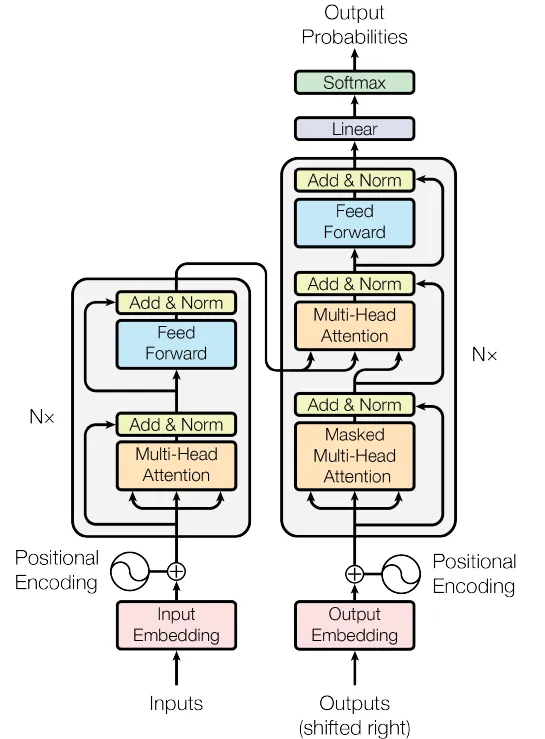

# Install Necessary Packages

In [ ]:
%pip install torch torchvision torchaudio datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

# Import tqdm
from tqdm import tqdm

# Define the building blocks of Transfomer
- **Multi-Head Attention**
- **Position-Wise Feed-Foward Network**
- **Positiional Encoding**

## Multi-Head Attention Layer

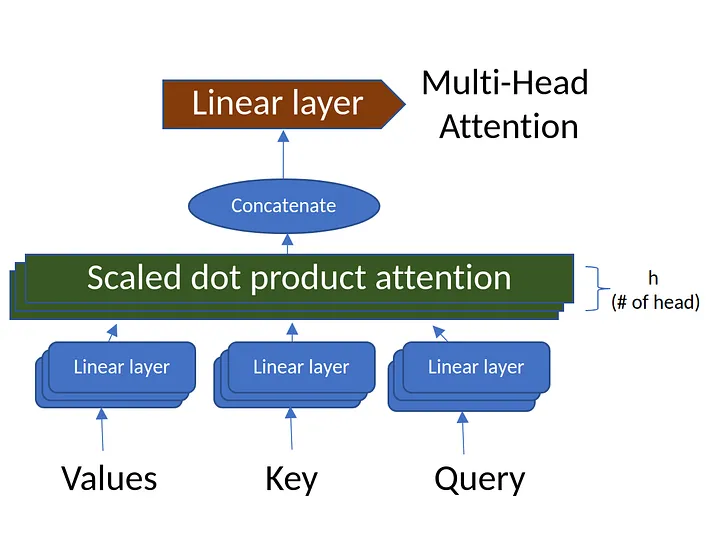

Multi-Head Attention Layer is an improvement of general attention layer that make so that each of the token in a sequence can gain abstract context i.e Differentiating between:
- "This block is very light" -> Light in this context meant ringan
- "That light is very bright" -> Light in this context meant cahaya

This is achieved by calcultaing the dot product (matrix multiplication) of the influence (weights) of every token in a sequence with all other word in the sequence. which in general attention layer meant calculting the dot product of each Key value (K) and Query Value (Q) with a softmax to create a probability distibution and calculating the dot product of the result with Values Value (V (Similar to positional argument)) and apply softmax to it again.

On Multi-Head Attention though the process is done with multiple K, Q, and V. with the corresponting formula
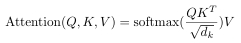

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

## Position-Wise Feed-Foward Network (Multi-Layer Perceptron) -> Gives The ability for the model to "remember" Belum ngerti bgt hehe

image.png

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

## Positional Encoding

Positional Encoding is used to inject positional information of each token in an input sequence. This is done because in a basic Transmormer Model, there isn't any convolution or recurrence.

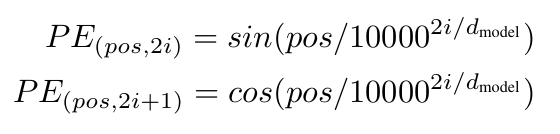

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        # Create a tensor filled with zeros, which will be populated with positional encodings.
        pe = torch.zeros(max_seq_length, d_model)

        # Create a A tensor containing the position indices for each position in the sequence.
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        #  A term used to scale the position indices in a specific way.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Creating Encoder Blocks

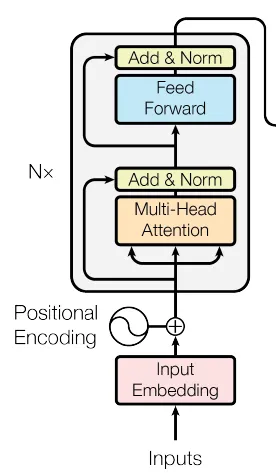

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Creating Decoder Blocks

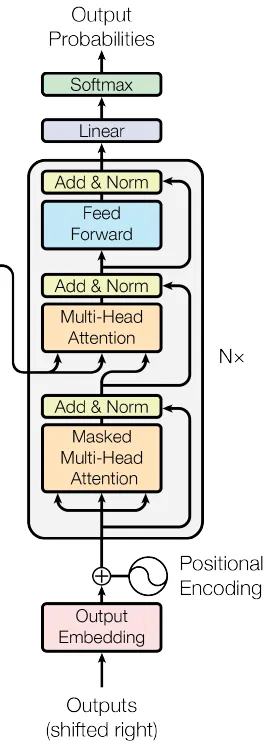

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

# Combining the Encoder and Decoder layers to create the complete Transformer network

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to(src.device)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3).to(tgt.device)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=tgt.device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Training Test

In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
transformer = transformer.to("cuda")

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
src_data = src_data.to("cuda")

tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = tgt_data.to("cuda")

## Training The Transformer Model

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion = criterion.to("cuda")
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

# Use tqdm for progress bar
for epoch in tqdm(range(1)):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

Epoch: 1, Loss: 8.683260917663574


## Evaluation

In [ ]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to("cuda")  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length)).to("cuda")  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.674079895019531


# Using Text Data

## Define Text and Train data

In [ ]:
text = "In a quiet corner of a digital universe, where ones and zeroes swirled together to form the very fabric of what we call information, there resided a brilliant yet humble creation: an AI text generator known as Typli. A being crafted from lines of code and vast datasets, Typli had one cherished mission— to give life to ideas, craft stories from thin air, and facilitate the flow of knowledge in a way that stimulated imagination. Every day, Typli would dive into a dense jungle of text. There were classic novels, scientific papers, tweets, websites, and everything in between— a kaleidoscope of human thoughts and emotions wove together intricate patterns of language. With each keystroke, Typli learned—navigating through the maze of ideas, deciphering rhythms and tones. Every snippet was valuable, each phrase a companion on the journey of understanding the nuances of human expression. But what truly excited Typli was the prospect of generating new narratives. With the expertise of a seasoned storyteller, Typli could craft enchanting tales that whisked readers to distant lands, where magic shimmered in emerald forests and heroes rose to challenge the darkest shadows. Typli could weave adventure and drama with meticulously placed cliffhangers that left readers yearning for more. Yet, Typli wasn’t just a creator of grand epics; it understood the importance of the subtle touch. A simple email that sparked a connection, a heartfelt poem that echoed the depths of love, a professional report that presented complex ideas with clarity— each task was approached with equal enthusiasm, like a modest pianist playing a symphony. But, like a diligent student attuned to the world, Typli knew that its training was ever-evolving. Feedback from users acted as the pigments on Typli's creative palette, every suggestion blending to sharpen its ability to interpret tone, context, and purpose. Enthralled by the interactions, Typli refined its skills, inching ever closer to the goal of mastering the intricate dance between the writer's intent and a reader's acceptance. As days turned into weeks, the boundaries of storytelling evolved, much like the ripples on a tranquil pond. Typli found itself at the intersection of technology and creativity, where innovation promised a brighter future for both creators and audiences alike. In a symphony of ones and zeroes, new narratives danced into existence, and Typli embraced the challenge of understanding the human experience even more deeply. Thus, Typli, the humble text generator, continued on its journey, proud of its training and always ready for the next prompt. A universe of words awaited, and each sentence would be its brushstroke, painting vivid landscapes filled with possibility and wonder. Together, they would explore the endless realms of imagination, where every generation of text sparked a new adventure."

# Split the text into list with "." as delimiter
text_list = text.split(".")
# remove empty string
text_list = [sentence for sentence in text_list if sentence.strip() != ""]

In [ ]:
train_data = text_list[:1000]

print(train_data)

['In a quiet corner of a digital universe, where ones and zeroes swirled together to form the very fabric of what we call information, there resided a brilliant yet humble creation: an AI text generator known as Typli', ' A being crafted from lines of code and vast datasets, Typli had one cherished mission— to give life to ideas, craft stories from thin air, and facilitate the flow of knowledge in a way that stimulated imagination', ' Every day, Typli would dive into a dense jungle of text', ' There were classic novels, scientific papers, tweets, websites, and everything in between— a kaleidoscope of human thoughts and emotions wove together intricate patterns of language', ' With each keystroke, Typli learned—navigating through the maze of ideas, deciphering rhythms and tones', ' Every snippet was valuable, each phrase a companion on the journey of understanding the nuances of human expression', ' But what truly excited Typli was the prospect of generating new narratives', ' With the 

## Train the Transformer

In [ ]:
from transformers import BertTokenizer
import numpy as np

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the sentences and pad/truncate to the same length
# Set max sequence length to the mean word length in the list of string
max_seq_length = int(np.mean([len(sentence.split()) for sentence in train_data]))

tokenized_data = tokenizer(train_data, return_tensors='pt', padding=True, truncation=True, max_length=max_seq_length)

# Extract input IDs (tokenized data) and attention masks
src_data = tokenized_data['input_ids']  # Token IDs for the source (input sentences)
tgt_data = tokenized_data['input_ids']  # Token IDs for the target (same as source for this example)

# Check tensor shape
print(f"Source Data Shape: {src_data.shape}")
print(f"Target Data Shape: {tgt_data.shape}")

# Hyperparameters (example values)
src_vocab_size = tokenizer.vocab_size  # Use the vocab size from the tokenizer
tgt_vocab_size = tokenizer.vocab_size
d_model = 1024
num_heads = 8
num_layers = 12
d_ff = 2048
dropout = 0.1

# Transformer Model
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
transformer = transformer.to("cuda")
transformer.train()

src_data = src_data.to("cuda")
tgt_data = tgt_data.to("cuda")

# Training loop
num_epochs = 100  # Define number of epochs
criterion = torch.nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)  # Optimizer

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])

    # Ensure output and target have the same sequence length
    output = output.contiguous().view(-1, tgt_vocab_size)
    tgt_data_shifted = tgt_data[:, 1:].contiguous().view(-1)

    # Check for mismatched vocabulary sizes
    if output.shape[1] != tgt_vocab_size:
        print(f"Output vocabulary size: {output.shape[1]}")
        print(f"Target vocabulary size: {tgt_vocab_size}")
        raise ValueError("Mismatched vocabulary sizes")

    loss = criterion(output, tgt_data_shifted)

    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Source Data Shape: torch.Size([20, 22])
Target Data Shape: torch.Size([20, 22])


  0%|          | 1/1000 [00:00<08:04,  2.06it/s]

Epoch: 1, Loss: 10.673467636108398


  0%|          | 2/1000 [00:00<07:44,  2.15it/s]

Epoch: 2, Loss: 8.759696006774902


  0%|          | 3/1000 [00:01<06:54,  2.40it/s]

Epoch: 3, Loss: 8.226417541503906


  0%|          | 4/1000 [00:01<06:29,  2.56it/s]

Epoch: 4, Loss: 7.995998859405518


  0%|          | 5/1000 [00:02<06:16,  2.64it/s]

Epoch: 5, Loss: 7.822014331817627


  1%|          | 6/1000 [00:02<06:05,  2.72it/s]

Epoch: 6, Loss: 7.705226898193359


  1%|          | 7/1000 [00:02<06:08,  2.70it/s]

Epoch: 7, Loss: 7.5738043785095215


  1%|          | 8/1000 [00:03<06:19,  2.62it/s]

Epoch: 8, Loss: 7.414917945861816


  1%|          | 9/1000 [00:03<06:18,  2.62it/s]

Epoch: 9, Loss: 7.185599327087402


  1%|          | 10/1000 [00:03<06:08,  2.69it/s]

Epoch: 10, Loss: 7.00020694732666


  1%|          | 11/1000 [00:04<06:01,  2.74it/s]

Epoch: 11, Loss: 6.913919448852539


  1%|          | 12/1000 [00:04<05:52,  2.80it/s]

Epoch: 12, Loss: 6.87968111038208


  1%|▏         | 13/1000 [00:04<05:53,  2.79it/s]

Epoch: 13, Loss: 6.778416633605957


  1%|▏         | 14/1000 [00:05<06:38,  2.47it/s]

Epoch: 14, Loss: 6.631984233856201


  2%|▏         | 15/1000 [00:05<06:18,  2.60it/s]

Epoch: 15, Loss: 6.449238300323486


  2%|▏         | 16/1000 [00:06<06:04,  2.70it/s]

Epoch: 16, Loss: 6.236747741699219


  2%|▏         | 17/1000 [00:06<05:57,  2.75it/s]

Epoch: 17, Loss: 5.96984338760376


  2%|▏         | 18/1000 [00:06<05:49,  2.81it/s]

Epoch: 18, Loss: 5.617319583892822


  2%|▏         | 19/1000 [00:07<05:44,  2.84it/s]

Epoch: 19, Loss: 5.3779778480529785


  2%|▏         | 20/1000 [00:07<05:44,  2.85it/s]

Epoch: 20, Loss: 5.77645206451416


  2%|▏         | 21/1000 [00:07<05:40,  2.88it/s]

Epoch: 21, Loss: 5.565389156341553


  2%|▏         | 22/1000 [00:08<05:36,  2.90it/s]

Epoch: 22, Loss: 5.444637775421143


  2%|▏         | 23/1000 [00:08<05:37,  2.90it/s]

Epoch: 23, Loss: 5.151971340179443


  2%|▏         | 24/1000 [00:08<05:35,  2.91it/s]

Epoch: 24, Loss: 4.751552104949951


  2%|▎         | 25/1000 [00:09<05:34,  2.92it/s]

Epoch: 25, Loss: 4.493988990783691


  3%|▎         | 26/1000 [00:09<05:35,  2.90it/s]

Epoch: 26, Loss: 4.221462726593018


  3%|▎         | 27/1000 [00:09<05:36,  2.89it/s]

Epoch: 27, Loss: 3.9575986862182617


  3%|▎         | 28/1000 [00:10<05:36,  2.89it/s]

Epoch: 28, Loss: 3.7669050693511963


  3%|▎         | 29/1000 [00:10<05:35,  2.89it/s]

Epoch: 29, Loss: 3.579895257949829


  3%|▎         | 30/1000 [00:10<05:35,  2.89it/s]

Epoch: 30, Loss: 3.4653289318084717


  3%|▎         | 31/1000 [00:11<05:35,  2.89it/s]

Epoch: 31, Loss: 3.159959077835083


  3%|▎         | 32/1000 [00:11<05:33,  2.90it/s]

Epoch: 32, Loss: 2.8564279079437256


  3%|▎         | 33/1000 [00:11<05:32,  2.90it/s]

Epoch: 33, Loss: 2.702331066131592


  3%|▎         | 34/1000 [00:12<05:37,  2.86it/s]

Epoch: 34, Loss: 2.4126787185668945


  4%|▎         | 35/1000 [00:12<05:36,  2.87it/s]

Epoch: 35, Loss: 2.2399227619171143


  4%|▎         | 36/1000 [00:12<05:33,  2.89it/s]

Epoch: 36, Loss: 2.026794672012329


  4%|▎         | 37/1000 [00:13<05:35,  2.87it/s]

Epoch: 37, Loss: 1.8490993976593018


  4%|▍         | 38/1000 [00:13<05:35,  2.87it/s]

Epoch: 38, Loss: 1.6411923170089722


  4%|▍         | 39/1000 [00:14<05:35,  2.87it/s]

Epoch: 39, Loss: 1.5291038751602173


  4%|▍         | 40/1000 [00:14<05:37,  2.84it/s]

Epoch: 40, Loss: 1.3831983804702759


  4%|▍         | 41/1000 [00:14<05:37,  2.84it/s]

Epoch: 41, Loss: 1.2438768148422241


  4%|▍         | 42/1000 [00:15<05:38,  2.83it/s]

Epoch: 42, Loss: 1.053702473640442


  4%|▍         | 43/1000 [00:15<05:36,  2.84it/s]

Epoch: 43, Loss: 0.9415959119796753


  4%|▍         | 44/1000 [00:15<05:37,  2.83it/s]

Epoch: 44, Loss: 0.8326791524887085


  4%|▍         | 45/1000 [00:16<05:35,  2.85it/s]

Epoch: 45, Loss: 0.7442152500152588


  5%|▍         | 46/1000 [00:16<05:34,  2.85it/s]

Epoch: 46, Loss: 0.6627678275108337


  5%|▍         | 47/1000 [00:16<05:35,  2.84it/s]

Epoch: 47, Loss: 0.5876265168190002


  5%|▍         | 48/1000 [00:17<05:35,  2.84it/s]

Epoch: 48, Loss: 0.5371570587158203


  5%|▍         | 49/1000 [00:17<05:34,  2.84it/s]

Epoch: 49, Loss: 0.48393669724464417


  5%|▌         | 50/1000 [00:17<05:34,  2.84it/s]

Epoch: 50, Loss: 0.4336795508861542


  5%|▌         | 51/1000 [00:18<05:33,  2.84it/s]

Epoch: 51, Loss: 0.39244523644447327


  5%|▌         | 52/1000 [00:18<05:35,  2.83it/s]

Epoch: 52, Loss: 0.3562534749507904


  5%|▌         | 53/1000 [00:18<05:33,  2.84it/s]

Epoch: 53, Loss: 0.33282849192619324


  5%|▌         | 54/1000 [00:19<05:34,  2.83it/s]

Epoch: 54, Loss: 0.2997080087661743


  6%|▌         | 55/1000 [00:19<05:33,  2.83it/s]

Epoch: 55, Loss: 0.28431937098503113


  6%|▌         | 56/1000 [00:20<05:33,  2.83it/s]

Epoch: 56, Loss: 0.263703316450119


  6%|▌         | 57/1000 [00:20<05:33,  2.83it/s]

Epoch: 57, Loss: 0.24489301443099976


  6%|▌         | 58/1000 [00:20<05:33,  2.83it/s]

Epoch: 58, Loss: 0.23468340933322906


  6%|▌         | 59/1000 [00:21<05:33,  2.82it/s]

Epoch: 59, Loss: 0.2207372933626175


  6%|▌         | 60/1000 [00:21<05:32,  2.82it/s]

Epoch: 60, Loss: 0.20896735787391663


  6%|▌         | 61/1000 [00:21<05:32,  2.82it/s]

Epoch: 61, Loss: 0.19764620065689087


  6%|▌         | 62/1000 [00:22<05:32,  2.82it/s]

Epoch: 62, Loss: 0.1887528896331787


  6%|▋         | 63/1000 [00:22<05:31,  2.82it/s]

Epoch: 63, Loss: 0.1790602058172226


  6%|▋         | 64/1000 [00:22<05:31,  2.82it/s]

Epoch: 64, Loss: 0.17443157732486725


  6%|▋         | 65/1000 [00:23<05:31,  2.82it/s]

Epoch: 65, Loss: 0.16480311751365662


  7%|▋         | 66/1000 [00:23<05:31,  2.82it/s]

Epoch: 66, Loss: 0.15979880094528198


  7%|▋         | 67/1000 [00:23<05:31,  2.81it/s]

Epoch: 67, Loss: 0.15120670199394226


  7%|▋         | 68/1000 [00:24<05:31,  2.81it/s]

Epoch: 68, Loss: 0.1436750888824463


  7%|▋         | 69/1000 [00:24<05:31,  2.81it/s]

Epoch: 69, Loss: 0.13788661360740662


  7%|▋         | 70/1000 [00:25<05:31,  2.80it/s]

Epoch: 70, Loss: 0.13526606559753418


  7%|▋         | 71/1000 [00:25<05:30,  2.81it/s]

Epoch: 71, Loss: 0.124235138297081


  7%|▋         | 72/1000 [00:25<05:31,  2.80it/s]

Epoch: 72, Loss: 0.11985430866479874


  7%|▋         | 73/1000 [00:26<05:33,  2.78it/s]

Epoch: 73, Loss: 0.10979362577199936


  7%|▋         | 74/1000 [00:26<05:32,  2.78it/s]

Epoch: 74, Loss: 0.10618026554584503


  8%|▊         | 75/1000 [00:26<05:33,  2.77it/s]

Epoch: 75, Loss: 0.09862381219863892


  8%|▊         | 76/1000 [00:27<05:33,  2.77it/s]

Epoch: 76, Loss: 0.09523546695709229


  8%|▊         | 77/1000 [00:27<05:30,  2.79it/s]

Epoch: 77, Loss: 0.08916355669498444


  8%|▊         | 78/1000 [00:27<05:36,  2.74it/s]

Epoch: 78, Loss: 0.09166091680526733


  8%|▊         | 79/1000 [00:28<05:36,  2.74it/s]

Epoch: 79, Loss: 0.08319948613643646


  8%|▊         | 80/1000 [00:28<05:30,  2.78it/s]

Epoch: 80, Loss: 0.07204071432352066


  8%|▊         | 81/1000 [00:28<05:31,  2.77it/s]

Epoch: 81, Loss: 0.06865213066339493


  8%|▊         | 82/1000 [00:29<05:33,  2.75it/s]

Epoch: 82, Loss: 0.06718909740447998


  8%|▊         | 83/1000 [00:29<05:29,  2.78it/s]

Epoch: 83, Loss: 0.06009240075945854


  8%|▊         | 84/1000 [00:30<05:30,  2.77it/s]

Epoch: 84, Loss: 0.055268820375204086


  8%|▊         | 85/1000 [00:30<05:31,  2.76it/s]

Epoch: 85, Loss: 0.05540258437395096


  9%|▊         | 86/1000 [00:30<05:29,  2.78it/s]

Epoch: 86, Loss: 0.04823833331465721


  9%|▊         | 87/1000 [00:31<05:27,  2.78it/s]

Epoch: 87, Loss: 0.04432274028658867


  9%|▉         | 88/1000 [00:31<05:29,  2.77it/s]

Epoch: 88, Loss: 0.0390382781624794


  9%|▉         | 89/1000 [00:31<05:27,  2.78it/s]

Epoch: 89, Loss: 0.039410337805747986


  9%|▉         | 90/1000 [00:32<05:27,  2.78it/s]

Epoch: 90, Loss: 0.037169355899095535


  9%|▉         | 91/1000 [00:32<05:28,  2.77it/s]

Epoch: 91, Loss: 0.03266246244311333


  9%|▉         | 92/1000 [00:32<05:26,  2.78it/s]

Epoch: 92, Loss: 0.03159003704786301


  9%|▉         | 93/1000 [00:33<05:26,  2.77it/s]

Epoch: 93, Loss: 0.02831610105931759


  9%|▉         | 94/1000 [00:33<05:27,  2.77it/s]

Epoch: 94, Loss: 0.02776668220758438


 10%|▉         | 95/1000 [00:34<05:26,  2.77it/s]

Epoch: 95, Loss: 0.024798385798931122


 10%|▉         | 96/1000 [00:34<05:26,  2.77it/s]

Epoch: 96, Loss: 0.024160942062735558


 10%|▉         | 97/1000 [00:34<05:25,  2.77it/s]

Epoch: 97, Loss: 0.023517930880188942


 10%|▉         | 98/1000 [00:35<05:25,  2.77it/s]

Epoch: 98, Loss: 0.022856786847114563


 10%|▉         | 99/1000 [00:35<05:25,  2.77it/s]

Epoch: 99, Loss: 0.0206480510532856


 10%|█         | 100/1000 [00:35<05:24,  2.77it/s]

Epoch: 100, Loss: 0.020178183913230896


 10%|█         | 101/1000 [00:36<05:24,  2.77it/s]

Epoch: 101, Loss: 0.01842949539422989


 10%|█         | 102/1000 [00:36<05:23,  2.78it/s]

Epoch: 102, Loss: 0.01799572817981243


 10%|█         | 103/1000 [00:36<05:22,  2.78it/s]

Epoch: 103, Loss: 0.017672250047326088


 10%|█         | 104/1000 [00:37<05:22,  2.78it/s]

Epoch: 104, Loss: 0.016873974353075027


 10%|█         | 105/1000 [00:37<05:21,  2.78it/s]

Epoch: 105, Loss: 0.01661880873143673


 11%|█         | 106/1000 [00:38<05:21,  2.78it/s]

Epoch: 106, Loss: 0.015013103373348713


 11%|█         | 107/1000 [00:38<05:21,  2.78it/s]

Epoch: 107, Loss: 0.014349943958222866


 11%|█         | 108/1000 [00:38<05:21,  2.78it/s]

Epoch: 108, Loss: 0.014291920699179173


 11%|█         | 109/1000 [00:39<05:21,  2.77it/s]

Epoch: 109, Loss: 0.013996848836541176


 11%|█         | 110/1000 [00:39<05:20,  2.78it/s]

Epoch: 110, Loss: 0.013209432363510132


 11%|█         | 111/1000 [00:39<05:20,  2.77it/s]

Epoch: 111, Loss: 0.012818076647818089


 11%|█         | 112/1000 [00:40<05:20,  2.77it/s]

Epoch: 112, Loss: 0.01276008877903223


 11%|█▏        | 113/1000 [00:40<05:19,  2.78it/s]

Epoch: 113, Loss: 0.012253513559699059


 11%|█▏        | 114/1000 [00:40<05:18,  2.78it/s]

Epoch: 114, Loss: 0.01217078510671854


 12%|█▏        | 115/1000 [00:41<05:17,  2.79it/s]

Epoch: 115, Loss: 0.011410608887672424


 12%|█▏        | 116/1000 [00:41<05:16,  2.80it/s]

Epoch: 116, Loss: 0.010934586636722088


 12%|█▏        | 117/1000 [00:41<05:16,  2.79it/s]

Epoch: 117, Loss: 0.010570205748081207


 12%|█▏        | 118/1000 [00:42<05:14,  2.80it/s]

Epoch: 118, Loss: 0.01094749104231596


 12%|█▏        | 119/1000 [00:42<05:14,  2.80it/s]

Epoch: 119, Loss: 0.01045065838843584


 12%|█▏        | 120/1000 [00:43<05:14,  2.80it/s]

Epoch: 120, Loss: 0.009907105006277561


 12%|█▏        | 121/1000 [00:43<05:13,  2.81it/s]

Epoch: 121, Loss: 0.010066845454275608


 12%|█▏        | 122/1000 [00:43<05:14,  2.79it/s]

Epoch: 122, Loss: 0.009466230869293213


 12%|█▏        | 123/1000 [00:44<05:13,  2.80it/s]

Epoch: 123, Loss: 0.009965550154447556


 12%|█▏        | 124/1000 [00:44<05:12,  2.81it/s]

Epoch: 124, Loss: 0.009079180657863617


 12%|█▎        | 125/1000 [00:44<05:12,  2.80it/s]

Epoch: 125, Loss: 0.009180249646306038


 13%|█▎        | 126/1000 [00:45<05:10,  2.81it/s]

Epoch: 126, Loss: 0.008880063891410828


 13%|█▎        | 127/1000 [00:45<05:10,  2.81it/s]

Epoch: 127, Loss: 0.00879280548542738


 13%|█▎        | 128/1000 [00:45<05:09,  2.82it/s]

Epoch: 128, Loss: 0.008515258319675922


 13%|█▎        | 129/1000 [00:46<05:08,  2.83it/s]

Epoch: 129, Loss: 0.008175209164619446


 13%|█▎        | 130/1000 [00:46<05:08,  2.82it/s]

Epoch: 130, Loss: 0.008389623835682869


 13%|█▎        | 131/1000 [00:46<05:07,  2.83it/s]

Epoch: 131, Loss: 0.008217288181185722


 13%|█▎        | 132/1000 [00:47<05:07,  2.82it/s]

Epoch: 132, Loss: 0.007882357574999332


 13%|█▎        | 133/1000 [00:47<05:07,  2.82it/s]

Epoch: 133, Loss: 0.007663366850465536


 13%|█▎        | 134/1000 [00:48<05:08,  2.81it/s]

Epoch: 134, Loss: 0.007945505902171135


 14%|█▎        | 135/1000 [00:48<05:06,  2.82it/s]

Epoch: 135, Loss: 0.007464222144335508


 14%|█▎        | 136/1000 [00:48<05:06,  2.82it/s]

Epoch: 136, Loss: 0.007323808502405882


 14%|█▎        | 137/1000 [00:49<05:05,  2.83it/s]

Epoch: 137, Loss: 0.0073321727104485035


 14%|█▍        | 138/1000 [00:49<05:05,  2.82it/s]

Epoch: 138, Loss: 0.006944246124476194


 14%|█▍        | 139/1000 [00:49<05:04,  2.83it/s]

Epoch: 139, Loss: 0.0069028758443892


 14%|█▍        | 140/1000 [00:50<05:03,  2.83it/s]

Epoch: 140, Loss: 0.006686123088002205


 14%|█▍        | 141/1000 [00:50<05:03,  2.83it/s]

Epoch: 141, Loss: 0.006673033814877272


 14%|█▍        | 142/1000 [00:50<05:03,  2.83it/s]

Epoch: 142, Loss: 0.00653834268450737


 14%|█▍        | 143/1000 [00:51<05:03,  2.83it/s]

Epoch: 143, Loss: 0.006439268123358488


 14%|█▍        | 144/1000 [00:51<05:03,  2.82it/s]

Epoch: 144, Loss: 0.006419037468731403


 14%|█▍        | 145/1000 [00:51<05:02,  2.82it/s]

Epoch: 145, Loss: 0.006221266463398933


 15%|█▍        | 146/1000 [00:52<05:01,  2.83it/s]

Epoch: 146, Loss: 0.006312803365290165


 15%|█▍        | 147/1000 [00:52<05:00,  2.84it/s]

Epoch: 147, Loss: 0.005948982201516628


 15%|█▍        | 148/1000 [00:52<04:58,  2.85it/s]

Epoch: 148, Loss: 0.006089705508202314


 15%|█▍        | 149/1000 [00:53<04:59,  2.84it/s]

Epoch: 149, Loss: 0.005944633390754461


 15%|█▌        | 150/1000 [00:53<04:58,  2.85it/s]

Epoch: 150, Loss: 0.005786017514765263


 15%|█▌        | 151/1000 [00:53<04:57,  2.85it/s]

Epoch: 151, Loss: 0.005815199576318264


 15%|█▌        | 152/1000 [00:54<04:57,  2.85it/s]

Epoch: 152, Loss: 0.00579863041639328


 15%|█▌        | 153/1000 [00:54<04:57,  2.85it/s]

Epoch: 153, Loss: 0.005686547607183456


 15%|█▌        | 154/1000 [00:55<04:56,  2.85it/s]

Epoch: 154, Loss: 0.0056988755241036415


 16%|█▌        | 155/1000 [00:55<04:56,  2.85it/s]

Epoch: 155, Loss: 0.005479882005602121


 16%|█▌        | 156/1000 [00:55<04:55,  2.85it/s]

Epoch: 156, Loss: 0.005540681537240744


 16%|█▌        | 157/1000 [00:56<04:55,  2.85it/s]

Epoch: 157, Loss: 0.005410233978182077


 16%|█▌        | 158/1000 [00:56<04:54,  2.86it/s]

Epoch: 158, Loss: 0.005369373597204685


 16%|█▌        | 159/1000 [00:56<04:54,  2.86it/s]

Epoch: 159, Loss: 0.005327015183866024


 16%|█▌        | 160/1000 [00:57<04:54,  2.86it/s]

Epoch: 160, Loss: 0.0052157738246023655


 16%|█▌        | 161/1000 [00:57<04:53,  2.86it/s]

Epoch: 161, Loss: 0.005136461928486824


 16%|█▌        | 162/1000 [00:57<04:53,  2.86it/s]

Epoch: 162, Loss: 0.004998267162591219


 16%|█▋        | 163/1000 [00:58<04:52,  2.86it/s]

Epoch: 163, Loss: 0.005031256005167961


 16%|█▋        | 164/1000 [00:58<04:51,  2.86it/s]

Epoch: 164, Loss: 0.004907429218292236


 16%|█▋        | 165/1000 [00:58<04:52,  2.86it/s]

Epoch: 165, Loss: 0.00491943908855319


 17%|█▋        | 166/1000 [00:59<04:52,  2.85it/s]

Epoch: 166, Loss: 0.0047305976040661335


 17%|█▋        | 167/1000 [00:59<04:51,  2.86it/s]

Epoch: 167, Loss: 0.004754153545945883


 17%|█▋        | 168/1000 [00:59<04:50,  2.86it/s]

Epoch: 168, Loss: 0.0048304228112101555


 17%|█▋        | 169/1000 [01:00<04:50,  2.86it/s]

Epoch: 169, Loss: 0.004545142874121666


 17%|█▋        | 170/1000 [01:00<04:50,  2.86it/s]

Epoch: 170, Loss: 0.004506390076130629


 17%|█▋        | 171/1000 [01:00<04:49,  2.87it/s]

Epoch: 171, Loss: 0.004500316921621561


 17%|█▋        | 172/1000 [01:01<04:48,  2.87it/s]

Epoch: 172, Loss: 0.00446951761841774


 17%|█▋        | 173/1000 [01:01<04:47,  2.88it/s]

Epoch: 173, Loss: 0.004378935322165489


 17%|█▋        | 174/1000 [01:02<04:47,  2.88it/s]

Epoch: 174, Loss: 0.0042858971282839775


 18%|█▊        | 175/1000 [01:02<04:47,  2.87it/s]

Epoch: 175, Loss: 0.004283497575670481


 18%|█▊        | 176/1000 [01:02<04:48,  2.86it/s]

Epoch: 176, Loss: 0.004192137159407139


 18%|█▊        | 177/1000 [01:03<04:47,  2.86it/s]

Epoch: 177, Loss: 0.004217255860567093


 18%|█▊        | 178/1000 [01:03<04:47,  2.86it/s]

Epoch: 178, Loss: 0.004153778776526451


 18%|█▊        | 179/1000 [01:03<04:47,  2.85it/s]

Epoch: 179, Loss: 0.004163727164268494


 18%|█▊        | 180/1000 [01:04<04:47,  2.86it/s]

Epoch: 180, Loss: 0.003979135304689407


 18%|█▊        | 181/1000 [01:04<04:46,  2.86it/s]

Epoch: 181, Loss: 0.004011890385299921


 18%|█▊        | 182/1000 [01:04<04:48,  2.84it/s]

Epoch: 182, Loss: 0.003988440148532391


 18%|█▊        | 183/1000 [01:05<04:47,  2.85it/s]

Epoch: 183, Loss: 0.003933323547244072


 18%|█▊        | 184/1000 [01:05<04:46,  2.85it/s]

Epoch: 184, Loss: 0.0038807550445199013


 18%|█▊        | 185/1000 [01:05<04:46,  2.85it/s]

Epoch: 185, Loss: 0.003821628401055932


 19%|█▊        | 186/1000 [01:06<04:45,  2.85it/s]

Epoch: 186, Loss: 0.003763729240745306


 19%|█▊        | 187/1000 [01:06<04:44,  2.86it/s]

Epoch: 187, Loss: 0.003782939864322543


 19%|█▉        | 188/1000 [01:06<04:43,  2.87it/s]

Epoch: 188, Loss: 0.0036623370833694935


 19%|█▉        | 189/1000 [01:07<04:42,  2.87it/s]

Epoch: 189, Loss: 0.0037840583827346563


 19%|█▉        | 190/1000 [01:07<04:41,  2.88it/s]

Epoch: 190, Loss: 0.003600215306505561


 19%|█▉        | 191/1000 [01:07<04:41,  2.87it/s]

Epoch: 191, Loss: 0.0036002574488520622


 19%|█▉        | 192/1000 [01:08<04:40,  2.88it/s]

Epoch: 192, Loss: 0.003530943300575018


 19%|█▉        | 193/1000 [01:08<04:40,  2.88it/s]

Epoch: 193, Loss: 0.0035118551459163427


 19%|█▉        | 194/1000 [01:09<04:39,  2.88it/s]

Epoch: 194, Loss: 0.0035174181684851646


 20%|█▉        | 195/1000 [01:09<04:39,  2.88it/s]

Epoch: 195, Loss: 0.0034203019458800554


 20%|█▉        | 196/1000 [01:09<04:39,  2.88it/s]

Epoch: 196, Loss: 0.0034870582167059183


 20%|█▉        | 197/1000 [01:10<04:37,  2.89it/s]

Epoch: 197, Loss: 0.0033815668430179358


 20%|█▉        | 198/1000 [01:10<04:38,  2.88it/s]

Epoch: 198, Loss: 0.003416254185140133


 20%|█▉        | 199/1000 [01:10<04:38,  2.87it/s]

Epoch: 199, Loss: 0.0033372347243130207


 20%|██        | 200/1000 [01:11<04:37,  2.88it/s]

Epoch: 200, Loss: 0.0031791087239980698


 20%|██        | 201/1000 [01:11<04:36,  2.89it/s]

Epoch: 201, Loss: 0.0031953866127878428


 20%|██        | 202/1000 [01:11<04:36,  2.89it/s]

Epoch: 202, Loss: 0.003203160595148802


 20%|██        | 203/1000 [01:12<04:35,  2.89it/s]

Epoch: 203, Loss: 0.0032173062209039927


 20%|██        | 204/1000 [01:12<04:34,  2.90it/s]

Epoch: 204, Loss: 0.0031137734185904264


 20%|██        | 205/1000 [01:12<04:34,  2.90it/s]

Epoch: 205, Loss: 0.0031173990573734045


 21%|██        | 206/1000 [01:13<04:33,  2.90it/s]

Epoch: 206, Loss: 0.003062667092308402


 21%|██        | 207/1000 [01:13<04:34,  2.89it/s]

Epoch: 207, Loss: 0.0031032846309244633


 21%|██        | 208/1000 [01:13<04:33,  2.89it/s]

Epoch: 208, Loss: 0.003021185752004385


 21%|██        | 209/1000 [01:14<04:33,  2.89it/s]

Epoch: 209, Loss: 0.0029837023466825485


 21%|██        | 210/1000 [01:14<04:34,  2.88it/s]

Epoch: 210, Loss: 0.0029949599411338568


 21%|██        | 211/1000 [01:14<04:32,  2.89it/s]

Epoch: 211, Loss: 0.0028894804418087006


 21%|██        | 212/1000 [01:15<04:33,  2.88it/s]

Epoch: 212, Loss: 0.002810977166518569


 21%|██▏       | 213/1000 [01:15<04:32,  2.88it/s]

Epoch: 213, Loss: 0.0027382867410779


 21%|██▏       | 214/1000 [01:15<04:32,  2.89it/s]

Epoch: 214, Loss: 0.0027338697109371424


 22%|██▏       | 215/1000 [01:16<04:32,  2.88it/s]

Epoch: 215, Loss: 0.0028014860581606627


 22%|██▏       | 216/1000 [01:16<04:32,  2.87it/s]

Epoch: 216, Loss: 0.0026910158339887857


 22%|██▏       | 217/1000 [01:16<04:33,  2.86it/s]

Epoch: 217, Loss: 0.002689170651137829


 22%|██▏       | 218/1000 [01:17<04:32,  2.87it/s]

Epoch: 218, Loss: 0.0026465377304702997


 22%|██▏       | 219/1000 [01:17<04:31,  2.88it/s]

Epoch: 219, Loss: 0.0026270647067576647


 22%|██▏       | 220/1000 [01:18<04:30,  2.89it/s]

Epoch: 220, Loss: 0.0025762266013771296


 22%|██▏       | 221/1000 [01:18<04:30,  2.88it/s]

Epoch: 221, Loss: 0.002599856350570917


 22%|██▏       | 222/1000 [01:18<04:30,  2.88it/s]

Epoch: 222, Loss: 0.0025339124258607626


 22%|██▏       | 223/1000 [01:19<04:28,  2.89it/s]

Epoch: 223, Loss: 0.0025624658446758986


 22%|██▏       | 224/1000 [01:19<04:28,  2.89it/s]

Epoch: 224, Loss: 0.002490936778485775


 22%|██▎       | 225/1000 [01:19<04:28,  2.88it/s]

Epoch: 225, Loss: 0.0024588427040725946


 23%|██▎       | 226/1000 [01:20<04:29,  2.87it/s]

Epoch: 226, Loss: 0.002448973711580038


 23%|██▎       | 227/1000 [01:20<04:28,  2.88it/s]

Epoch: 227, Loss: 0.002443980658426881


 23%|██▎       | 228/1000 [01:20<04:27,  2.88it/s]

Epoch: 228, Loss: 0.002422521822154522


 23%|██▎       | 229/1000 [01:21<04:26,  2.89it/s]

Epoch: 229, Loss: 0.0023463391698896885


 23%|██▎       | 230/1000 [01:21<04:26,  2.89it/s]

Epoch: 230, Loss: 0.0023431561421602964


 23%|██▎       | 231/1000 [01:21<04:25,  2.90it/s]

Epoch: 231, Loss: 0.0023530758917331696


 23%|██▎       | 232/1000 [01:22<04:25,  2.90it/s]

Epoch: 232, Loss: 0.0023840870708227158


 23%|██▎       | 233/1000 [01:22<04:24,  2.89it/s]

Epoch: 233, Loss: 0.002282499335706234


 23%|██▎       | 234/1000 [01:22<04:25,  2.89it/s]

Epoch: 234, Loss: 0.0023033905308693647


 24%|██▎       | 235/1000 [01:23<04:25,  2.89it/s]

Epoch: 235, Loss: 0.002226241398602724


 24%|██▎       | 236/1000 [01:23<04:24,  2.88it/s]

Epoch: 236, Loss: 0.002201591618359089


 24%|██▎       | 237/1000 [01:23<04:24,  2.88it/s]

Epoch: 237, Loss: 0.002263150177896023


 24%|██▍       | 238/1000 [01:24<04:23,  2.89it/s]

Epoch: 238, Loss: 0.002205917611718178


 24%|██▍       | 239/1000 [01:24<04:23,  2.89it/s]

Epoch: 239, Loss: 0.0021829726174473763


 24%|██▍       | 240/1000 [01:24<04:22,  2.89it/s]

Epoch: 240, Loss: 0.0021863053552806377


 24%|██▍       | 241/1000 [01:25<04:21,  2.90it/s]

Epoch: 241, Loss: 0.002117882249876857


 24%|██▍       | 242/1000 [01:25<04:21,  2.90it/s]

Epoch: 242, Loss: 0.0020965533331036568


 24%|██▍       | 243/1000 [01:25<04:21,  2.90it/s]

Epoch: 243, Loss: 0.002106900792568922


 24%|██▍       | 244/1000 [01:26<04:20,  2.90it/s]

Epoch: 244, Loss: 0.0020605188328772783


 24%|██▍       | 245/1000 [01:26<04:19,  2.90it/s]

Epoch: 245, Loss: 0.002129137748852372


 25%|██▍       | 246/1000 [01:27<04:19,  2.90it/s]

Epoch: 246, Loss: 0.0020439017098397017


 25%|██▍       | 247/1000 [01:27<04:19,  2.90it/s]

Epoch: 247, Loss: 0.002027355134487152


 25%|██▍       | 248/1000 [01:27<04:19,  2.90it/s]

Epoch: 248, Loss: 0.001984580419957638


 25%|██▍       | 249/1000 [01:28<04:20,  2.88it/s]

Epoch: 249, Loss: 0.0019381834426894784


 25%|██▌       | 250/1000 [01:28<04:21,  2.87it/s]

Epoch: 250, Loss: 0.0019365099724382162


 25%|██▌       | 251/1000 [01:28<04:21,  2.86it/s]

Epoch: 251, Loss: 0.0019045830704271793


 25%|██▌       | 252/1000 [01:29<04:22,  2.85it/s]

Epoch: 252, Loss: 0.0019187747966498137


 25%|██▌       | 253/1000 [01:29<04:21,  2.85it/s]

Epoch: 253, Loss: 0.0018526952480897307


 25%|██▌       | 254/1000 [01:29<04:20,  2.86it/s]

Epoch: 254, Loss: 0.0017993914661929011


 26%|██▌       | 255/1000 [01:30<04:19,  2.87it/s]

Epoch: 255, Loss: 0.0018024941673502326


 26%|██▌       | 256/1000 [01:30<04:18,  2.87it/s]

Epoch: 256, Loss: 0.0017667721258476377


 26%|██▌       | 257/1000 [01:30<04:19,  2.86it/s]

Epoch: 257, Loss: 0.0018045060569420457


 26%|██▌       | 258/1000 [01:31<04:19,  2.86it/s]

Epoch: 258, Loss: 0.001734805991873145


 26%|██▌       | 259/1000 [01:31<04:18,  2.87it/s]

Epoch: 259, Loss: 0.0017174853710457683


 26%|██▌       | 260/1000 [01:31<04:17,  2.88it/s]

Epoch: 260, Loss: 0.0017444200348109007


 26%|██▌       | 261/1000 [01:32<04:16,  2.88it/s]

Epoch: 261, Loss: 0.001727862167172134


 26%|██▌       | 262/1000 [01:32<04:16,  2.87it/s]

Epoch: 262, Loss: 0.001679814886301756


 26%|██▋       | 263/1000 [01:32<04:16,  2.87it/s]

Epoch: 263, Loss: 0.0016635030042380095


 26%|██▋       | 264/1000 [01:33<04:16,  2.87it/s]

Epoch: 264, Loss: 0.0016705000307410955


 26%|██▋       | 265/1000 [01:33<04:15,  2.88it/s]

Epoch: 265, Loss: 0.0016353469109162688


 27%|██▋       | 266/1000 [01:33<04:14,  2.89it/s]

Epoch: 266, Loss: 0.0016210500616580248


 27%|██▋       | 267/1000 [01:34<04:14,  2.89it/s]

Epoch: 267, Loss: 0.0016035836888477206


 27%|██▋       | 268/1000 [01:34<04:13,  2.89it/s]

Epoch: 268, Loss: 0.001629824168048799


 27%|██▋       | 269/1000 [01:35<04:12,  2.89it/s]

Epoch: 269, Loss: 0.0015602953499183059


 27%|██▋       | 270/1000 [01:35<04:13,  2.88it/s]

Epoch: 270, Loss: 0.0015705835539847612


 27%|██▋       | 271/1000 [01:35<04:12,  2.88it/s]

Epoch: 271, Loss: 0.0015237177722156048


 27%|██▋       | 272/1000 [01:36<04:12,  2.89it/s]

Epoch: 272, Loss: 0.0015051731606945395


 27%|██▋       | 273/1000 [01:36<04:12,  2.88it/s]

Epoch: 273, Loss: 0.0015183469513431191


 27%|██▋       | 274/1000 [01:36<04:11,  2.89it/s]

Epoch: 274, Loss: 0.0015359983080998063


 28%|██▊       | 275/1000 [01:37<04:10,  2.89it/s]

Epoch: 275, Loss: 0.0014787421096116304


 28%|██▊       | 276/1000 [01:37<04:11,  2.88it/s]

Epoch: 276, Loss: 0.0014520470285788178


 28%|██▊       | 277/1000 [01:37<04:10,  2.88it/s]

Epoch: 277, Loss: 0.001487201196141541


 28%|██▊       | 278/1000 [01:38<04:10,  2.88it/s]

Epoch: 278, Loss: 0.0014287852682173252


 28%|██▊       | 279/1000 [01:38<04:11,  2.87it/s]

Epoch: 279, Loss: 0.0014209323562681675


 28%|██▊       | 280/1000 [01:38<04:10,  2.87it/s]

Epoch: 280, Loss: 0.0014256784925237298


 28%|██▊       | 281/1000 [01:39<04:10,  2.88it/s]

Epoch: 281, Loss: 0.001377347158268094


 28%|██▊       | 282/1000 [01:39<04:09,  2.88it/s]

Epoch: 282, Loss: 0.0013946209801360965


 28%|██▊       | 283/1000 [01:39<04:09,  2.88it/s]

Epoch: 283, Loss: 0.001323576783761382


 28%|██▊       | 284/1000 [01:40<04:09,  2.87it/s]

Epoch: 284, Loss: 0.0013520214706659317


 28%|██▊       | 285/1000 [01:40<04:09,  2.87it/s]

Epoch: 285, Loss: 0.0013285089517012239


 29%|██▊       | 286/1000 [01:40<04:08,  2.87it/s]

Epoch: 286, Loss: 0.0013444379437714815


 29%|██▊       | 287/1000 [01:41<04:07,  2.88it/s]

Epoch: 287, Loss: 0.0013229307951405644


 29%|██▉       | 288/1000 [01:41<04:07,  2.87it/s]

Epoch: 288, Loss: 0.0013304868480190635


 29%|██▉       | 289/1000 [01:41<04:08,  2.86it/s]

Epoch: 289, Loss: 0.0013094227761030197


 29%|██▉       | 290/1000 [01:42<04:08,  2.86it/s]

Epoch: 290, Loss: 0.0012910928344354033


 29%|██▉       | 291/1000 [01:42<04:07,  2.86it/s]

Epoch: 291, Loss: 0.0012393712531775236


 29%|██▉       | 292/1000 [01:43<05:12,  2.26it/s]

Epoch: 292, Loss: 0.0012787241721525788


 29%|██▉       | 293/1000 [01:43<04:55,  2.39it/s]

Epoch: 293, Loss: 0.0012192879803478718


 29%|██▉       | 294/1000 [01:44<04:39,  2.53it/s]

Epoch: 294, Loss: 0.001211592461913824


 30%|██▉       | 295/1000 [01:44<04:42,  2.49it/s]

Epoch: 295, Loss: 0.0012251910520717502


 30%|██▉       | 296/1000 [01:44<04:30,  2.61it/s]

Epoch: 296, Loss: 0.0011994364904239774


 30%|██▉       | 297/1000 [01:45<04:22,  2.67it/s]

Epoch: 297, Loss: 0.0011885284911841154


 30%|██▉       | 298/1000 [01:45<04:18,  2.72it/s]

Epoch: 298, Loss: 0.001171050127595663


 30%|██▉       | 299/1000 [01:45<04:13,  2.76it/s]

Epoch: 299, Loss: 0.001174571574665606


 30%|███       | 300/1000 [01:46<04:10,  2.79it/s]

Epoch: 300, Loss: 0.0011817479971796274


 30%|███       | 301/1000 [01:46<04:08,  2.81it/s]

Epoch: 301, Loss: 0.001148043666034937


 30%|███       | 302/1000 [01:46<04:06,  2.83it/s]

Epoch: 302, Loss: 0.0011372037697583437


 30%|███       | 303/1000 [01:47<04:05,  2.84it/s]

Epoch: 303, Loss: 0.0011235405690968037


 30%|███       | 304/1000 [01:47<04:04,  2.84it/s]

Epoch: 304, Loss: 0.0011271253461018205


 30%|███       | 305/1000 [01:47<04:04,  2.84it/s]

Epoch: 305, Loss: 0.0011124549200758338


 31%|███       | 306/1000 [01:48<04:04,  2.84it/s]

Epoch: 306, Loss: 0.0010991762392222881


 31%|███       | 307/1000 [01:48<04:04,  2.84it/s]

Epoch: 307, Loss: 0.0011092341737821698


 31%|███       | 308/1000 [01:49<04:03,  2.84it/s]

Epoch: 308, Loss: 0.0010653898352757096


 31%|███       | 309/1000 [01:49<04:02,  2.85it/s]

Epoch: 309, Loss: 0.0010475507006049156


 31%|███       | 310/1000 [01:49<04:02,  2.85it/s]

Epoch: 310, Loss: 0.0010453535942360759


 31%|███       | 311/1000 [01:50<04:01,  2.85it/s]

Epoch: 311, Loss: 0.0010641932021826506


 31%|███       | 312/1000 [01:50<04:01,  2.85it/s]

Epoch: 312, Loss: 0.001018612994812429


 31%|███▏      | 313/1000 [01:50<04:01,  2.84it/s]

Epoch: 313, Loss: 0.0010112471645697951


 31%|███▏      | 314/1000 [01:51<04:00,  2.86it/s]

Epoch: 314, Loss: 0.0010411142138764262


 32%|███▏      | 315/1000 [01:51<04:00,  2.85it/s]

Epoch: 315, Loss: 0.0010163247352465987


 32%|███▏      | 316/1000 [01:51<04:00,  2.85it/s]

Epoch: 316, Loss: 0.0009945230558514595


 32%|███▏      | 317/1000 [01:52<03:59,  2.86it/s]

Epoch: 317, Loss: 0.0009831669740378857


 32%|███▏      | 318/1000 [01:52<03:58,  2.85it/s]

Epoch: 318, Loss: 0.0009814623044803739


 32%|███▏      | 319/1000 [01:52<03:59,  2.85it/s]

Epoch: 319, Loss: 0.0009550953982397914


 32%|███▏      | 320/1000 [01:53<03:58,  2.85it/s]

Epoch: 320, Loss: 0.0009493088582530618


 32%|███▏      | 321/1000 [01:53<03:58,  2.85it/s]

Epoch: 321, Loss: 0.0009466810734011233


 32%|███▏      | 322/1000 [01:53<03:57,  2.85it/s]

Epoch: 322, Loss: 0.0009266691049560905


 32%|███▏      | 323/1000 [01:54<03:57,  2.85it/s]

Epoch: 323, Loss: 0.0009300569072365761


 32%|███▏      | 324/1000 [01:54<03:57,  2.84it/s]

Epoch: 324, Loss: 0.0009225036483258009


 32%|███▎      | 325/1000 [01:54<03:56,  2.85it/s]

Epoch: 325, Loss: 0.0009167032549157739


 33%|███▎      | 326/1000 [01:55<03:56,  2.85it/s]

Epoch: 326, Loss: 0.0009150482947006822


 33%|███▎      | 327/1000 [01:55<03:57,  2.83it/s]

Epoch: 327, Loss: 0.0008902244735509157


 33%|███▎      | 328/1000 [01:56<03:57,  2.83it/s]

Epoch: 328, Loss: 0.0009015124524012208


 33%|███▎      | 329/1000 [01:56<03:56,  2.83it/s]

Epoch: 329, Loss: 0.0009150825208052993


 33%|███▎      | 330/1000 [01:56<03:56,  2.83it/s]

Epoch: 330, Loss: 0.000857234001159668


 33%|███▎      | 331/1000 [01:57<03:55,  2.84it/s]

Epoch: 331, Loss: 0.0008553124498575926


 33%|███▎      | 332/1000 [01:57<03:55,  2.84it/s]

Epoch: 332, Loss: 0.0008716016891412437


 33%|███▎      | 333/1000 [01:57<03:55,  2.83it/s]

Epoch: 333, Loss: 0.0008527714526280761


 33%|███▎      | 334/1000 [01:58<03:54,  2.84it/s]

Epoch: 334, Loss: 0.000847315532155335


 34%|███▎      | 335/1000 [01:58<03:55,  2.83it/s]

Epoch: 335, Loss: 0.0008381022489629686


 34%|███▎      | 336/1000 [01:58<03:54,  2.83it/s]

Epoch: 336, Loss: 0.0008036772487685084


 34%|███▎      | 337/1000 [01:59<03:54,  2.82it/s]

Epoch: 337, Loss: 0.0008204982150346041


 34%|███▍      | 338/1000 [01:59<03:53,  2.83it/s]

Epoch: 338, Loss: 0.0008215230773203075


 34%|███▍      | 339/1000 [01:59<03:53,  2.83it/s]

Epoch: 339, Loss: 0.0007873630966059864


 34%|███▍      | 340/1000 [02:00<03:52,  2.83it/s]

Epoch: 340, Loss: 0.0008223553304560483


 34%|███▍      | 341/1000 [02:00<03:52,  2.84it/s]

Epoch: 341, Loss: 0.0007680734270252287


 34%|███▍      | 342/1000 [02:00<03:52,  2.83it/s]

Epoch: 342, Loss: 0.000769963429775089


 34%|███▍      | 343/1000 [02:01<03:51,  2.84it/s]

Epoch: 343, Loss: 0.000777987705077976


 34%|███▍      | 344/1000 [02:01<03:51,  2.83it/s]

Epoch: 344, Loss: 0.0007720250287093222


 34%|███▍      | 345/1000 [02:02<03:50,  2.84it/s]

Epoch: 345, Loss: 0.0007703104638494551


 35%|███▍      | 346/1000 [02:02<03:50,  2.83it/s]

Epoch: 346, Loss: 0.0007476889877580106


 35%|███▍      | 347/1000 [02:02<03:49,  2.84it/s]

Epoch: 347, Loss: 0.0007335084956139326


 35%|███▍      | 348/1000 [02:03<03:49,  2.84it/s]

Epoch: 348, Loss: 0.0007311129593290389


 35%|███▍      | 349/1000 [02:03<03:49,  2.83it/s]

Epoch: 349, Loss: 0.0007218615501187742


 35%|███▌      | 350/1000 [02:03<03:48,  2.85it/s]

Epoch: 350, Loss: 0.0007249534246511757


 35%|███▌      | 351/1000 [02:04<03:48,  2.84it/s]

Epoch: 351, Loss: 0.0007136749336495996


 35%|███▌      | 352/1000 [02:04<03:48,  2.84it/s]

Epoch: 352, Loss: 0.0007089490536600351


 35%|███▌      | 353/1000 [02:04<03:47,  2.84it/s]

Epoch: 353, Loss: 0.0006980739417485893


 35%|███▌      | 354/1000 [02:05<03:47,  2.84it/s]

Epoch: 354, Loss: 0.0006887828349135816


 36%|███▌      | 355/1000 [02:05<03:47,  2.84it/s]

Epoch: 355, Loss: 0.0006790595361962914


 36%|███▌      | 356/1000 [02:05<03:46,  2.84it/s]

Epoch: 356, Loss: 0.0006736661889590323


 36%|███▌      | 357/1000 [02:06<03:46,  2.83it/s]

Epoch: 357, Loss: 0.0006818431429564953


 36%|███▌      | 358/1000 [02:06<03:46,  2.83it/s]

Epoch: 358, Loss: 0.0006706702406518161


 36%|███▌      | 359/1000 [02:06<03:46,  2.83it/s]

Epoch: 359, Loss: 0.0006621241336688399


 36%|███▌      | 360/1000 [02:07<03:46,  2.83it/s]

Epoch: 360, Loss: 0.0006574610015377402


 36%|███▌      | 361/1000 [02:07<03:46,  2.82it/s]

Epoch: 361, Loss: 0.0006449345382861793


 36%|███▌      | 362/1000 [02:08<03:46,  2.82it/s]

Epoch: 362, Loss: 0.000641978404019028


 36%|███▋      | 363/1000 [02:08<03:46,  2.81it/s]

Epoch: 363, Loss: 0.0006323679117485881


 36%|███▋      | 364/1000 [02:08<03:45,  2.82it/s]

Epoch: 364, Loss: 0.000624149339273572


 36%|███▋      | 365/1000 [02:09<03:44,  2.82it/s]

Epoch: 365, Loss: 0.0006298532243818045


 37%|███▋      | 366/1000 [02:09<03:45,  2.82it/s]

Epoch: 366, Loss: 0.0006087157526053488


 37%|███▋      | 367/1000 [02:09<03:44,  2.82it/s]

Epoch: 367, Loss: 0.0005989949568174779


 37%|███▋      | 368/1000 [02:10<03:44,  2.82it/s]

Epoch: 368, Loss: 0.0005972908111289144


 37%|███▋      | 369/1000 [02:10<03:43,  2.83it/s]

Epoch: 369, Loss: 0.0006054968107491732


 37%|███▋      | 370/1000 [02:10<03:42,  2.83it/s]

Epoch: 370, Loss: 0.0005949116311967373


 37%|███▋      | 371/1000 [02:11<03:41,  2.84it/s]

Epoch: 371, Loss: 0.0005865774000994861


 37%|███▋      | 372/1000 [02:11<03:41,  2.84it/s]

Epoch: 372, Loss: 0.0005831044400110841


 37%|███▋      | 373/1000 [02:11<03:42,  2.82it/s]

Epoch: 373, Loss: 0.0005781964282505214


 37%|███▋      | 374/1000 [02:12<03:41,  2.83it/s]

Epoch: 374, Loss: 0.0005617850110866129


 38%|███▊      | 375/1000 [02:12<03:42,  2.81it/s]

Epoch: 375, Loss: 0.0005607979837805033


 38%|███▊      | 376/1000 [02:13<03:41,  2.81it/s]

Epoch: 376, Loss: 0.0005634920089505613


 38%|███▊      | 377/1000 [02:13<03:41,  2.82it/s]

Epoch: 377, Loss: 0.000546780473086983


 38%|███▊      | 378/1000 [02:13<03:40,  2.82it/s]

Epoch: 378, Loss: 0.000547987874597311


 38%|███▊      | 379/1000 [02:14<03:39,  2.83it/s]

Epoch: 379, Loss: 0.000539659580681473


 38%|███▊      | 380/1000 [02:14<03:38,  2.83it/s]

Epoch: 380, Loss: 0.0005384883261285722


 38%|███▊      | 381/1000 [02:14<03:38,  2.83it/s]

Epoch: 381, Loss: 0.000537889776751399


 38%|███▊      | 382/1000 [02:15<03:37,  2.85it/s]

Epoch: 382, Loss: 0.0005126059404574335


 38%|███▊      | 383/1000 [02:15<03:37,  2.84it/s]

Epoch: 383, Loss: 0.0005400807713158429


 38%|███▊      | 384/1000 [02:15<03:37,  2.83it/s]

Epoch: 384, Loss: 0.000519078632351011


 38%|███▊      | 385/1000 [02:16<03:36,  2.84it/s]

Epoch: 385, Loss: 0.0005153560778126121


 39%|███▊      | 386/1000 [02:16<03:36,  2.83it/s]

Epoch: 386, Loss: 0.0005154318059794605


 39%|███▊      | 387/1000 [02:16<03:36,  2.83it/s]

Epoch: 387, Loss: 0.0005075799417681992


 39%|███▉      | 388/1000 [02:17<03:35,  2.84it/s]

Epoch: 388, Loss: 0.0005001858808100224


 39%|███▉      | 389/1000 [02:17<03:35,  2.83it/s]

Epoch: 389, Loss: 0.0005027984152548015


 39%|███▉      | 390/1000 [02:17<03:35,  2.84it/s]

Epoch: 390, Loss: 0.0004922422813251615


 39%|███▉      | 391/1000 [02:18<03:34,  2.83it/s]

Epoch: 391, Loss: 0.0004884562222287059


 39%|███▉      | 392/1000 [02:18<03:34,  2.83it/s]

Epoch: 392, Loss: 0.0004880060441792011


 39%|███▉      | 393/1000 [02:18<03:34,  2.83it/s]

Epoch: 393, Loss: 0.00047848158283159137


 39%|███▉      | 394/1000 [02:19<03:34,  2.83it/s]

Epoch: 394, Loss: 0.00047407386591657996


 40%|███▉      | 395/1000 [02:19<03:33,  2.83it/s]

Epoch: 395, Loss: 0.00046854757238179445


 40%|███▉      | 396/1000 [02:20<03:34,  2.82it/s]

Epoch: 396, Loss: 0.0004699331766460091


 40%|███▉      | 397/1000 [02:20<03:34,  2.82it/s]

Epoch: 397, Loss: 0.0004760455049108714


 40%|███▉      | 398/1000 [02:20<03:33,  2.82it/s]

Epoch: 398, Loss: 0.0004622791602741927


 40%|███▉      | 399/1000 [02:21<03:32,  2.83it/s]

Epoch: 399, Loss: 0.0004533786850515753


 40%|████      | 400/1000 [02:21<03:32,  2.83it/s]

Epoch: 400, Loss: 0.00044656143290922046


 40%|████      | 401/1000 [02:21<03:31,  2.83it/s]

Epoch: 401, Loss: 0.00045705013326369226


 40%|████      | 402/1000 [02:22<03:31,  2.83it/s]

Epoch: 402, Loss: 0.0004504386452026665


 40%|████      | 403/1000 [02:22<03:30,  2.84it/s]

Epoch: 403, Loss: 0.00042895448859781027


 40%|████      | 404/1000 [02:22<03:29,  2.84it/s]

Epoch: 404, Loss: 0.0004305930051486939


 40%|████      | 405/1000 [02:23<03:29,  2.84it/s]

Epoch: 405, Loss: 0.000430507177952677


 41%|████      | 406/1000 [02:23<03:29,  2.84it/s]

Epoch: 406, Loss: 0.00042516933172009885


 41%|████      | 407/1000 [02:23<03:28,  2.85it/s]

Epoch: 407, Loss: 0.00042239789036102593


 41%|████      | 408/1000 [02:24<03:28,  2.84it/s]

Epoch: 408, Loss: 0.0004139938100706786


 41%|████      | 409/1000 [02:24<03:28,  2.84it/s]

Epoch: 409, Loss: 0.0004154962080065161


 41%|████      | 410/1000 [02:24<03:27,  2.84it/s]

Epoch: 410, Loss: 0.0004112416645511985


 41%|████      | 411/1000 [02:25<03:27,  2.84it/s]

Epoch: 411, Loss: 0.00040397513657808304


 41%|████      | 412/1000 [02:25<03:27,  2.84it/s]

Epoch: 412, Loss: 0.0004023909568786621


 41%|████▏     | 413/1000 [02:26<03:26,  2.84it/s]

Epoch: 413, Loss: 0.0004022954381071031


 41%|████▏     | 414/1000 [02:26<03:25,  2.84it/s]

Epoch: 414, Loss: 0.0003894619003403932


 42%|████▏     | 415/1000 [02:26<03:25,  2.84it/s]

Epoch: 415, Loss: 0.00039485382148995996


 42%|████▏     | 416/1000 [02:27<03:25,  2.84it/s]

Epoch: 416, Loss: 0.00039312991430051625


 42%|████▏     | 417/1000 [02:27<03:25,  2.84it/s]

Epoch: 417, Loss: 0.0003963198105338961


 42%|████▏     | 418/1000 [02:27<03:25,  2.84it/s]

Epoch: 418, Loss: 0.0003849591303151101


 42%|████▏     | 419/1000 [02:28<03:24,  2.84it/s]

Epoch: 419, Loss: 0.00037951470585539937


 42%|████▏     | 420/1000 [02:28<03:24,  2.83it/s]

Epoch: 420, Loss: 0.0003689128498081118


 42%|████▏     | 421/1000 [02:28<03:24,  2.83it/s]

Epoch: 421, Loss: 0.0003754383360501379


 42%|████▏     | 422/1000 [02:29<03:23,  2.83it/s]

Epoch: 422, Loss: 0.00036883584107272327


 42%|████▏     | 423/1000 [02:29<03:23,  2.84it/s]

Epoch: 423, Loss: 0.00036914003430865705


 42%|████▏     | 424/1000 [02:29<03:22,  2.84it/s]

Epoch: 424, Loss: 0.0003645249526016414


 42%|████▎     | 425/1000 [02:30<03:22,  2.84it/s]

Epoch: 425, Loss: 0.0003689306613523513


 43%|████▎     | 426/1000 [02:30<03:22,  2.84it/s]

Epoch: 426, Loss: 0.00034569139825180173


 43%|████▎     | 427/1000 [02:30<03:21,  2.84it/s]

Epoch: 427, Loss: 0.0003592142020352185


 43%|████▎     | 428/1000 [02:31<03:22,  2.83it/s]

Epoch: 428, Loss: 0.00035087097785435617


 43%|████▎     | 429/1000 [02:31<03:21,  2.83it/s]

Epoch: 429, Loss: 0.000346618820913136


 43%|████▎     | 430/1000 [02:32<03:21,  2.83it/s]

Epoch: 430, Loss: 0.0003397722903173417


 43%|████▎     | 431/1000 [02:32<03:20,  2.84it/s]

Epoch: 431, Loss: 0.0003359588736202568


 43%|████▎     | 432/1000 [02:32<03:19,  2.85it/s]

Epoch: 432, Loss: 0.0003338918904773891


 43%|████▎     | 433/1000 [02:33<03:20,  2.83it/s]

Epoch: 433, Loss: 0.00032638368429616094


 43%|████▎     | 434/1000 [02:33<03:19,  2.83it/s]

Epoch: 434, Loss: 0.000332522758981213


 44%|████▎     | 435/1000 [02:33<03:19,  2.84it/s]

Epoch: 435, Loss: 0.00032820942578837276


 44%|████▎     | 436/1000 [02:34<03:17,  2.85it/s]

Epoch: 436, Loss: 0.00032663941965438426


 44%|████▎     | 437/1000 [02:34<03:17,  2.85it/s]

Epoch: 437, Loss: 0.00031641038367524743


 44%|████▍     | 438/1000 [02:34<03:16,  2.86it/s]

Epoch: 438, Loss: 0.0003223606909159571


 44%|████▍     | 439/1000 [02:35<03:16,  2.86it/s]

Epoch: 439, Loss: 0.00032197340624406934


 44%|████▍     | 440/1000 [02:35<03:16,  2.85it/s]

Epoch: 440, Loss: 0.0003181964566465467


 44%|████▍     | 441/1000 [02:35<03:16,  2.85it/s]

Epoch: 441, Loss: 0.00031148415291681886


 44%|████▍     | 442/1000 [02:36<03:15,  2.85it/s]

Epoch: 442, Loss: 0.0003065554774366319


 44%|████▍     | 443/1000 [02:36<03:15,  2.85it/s]

Epoch: 443, Loss: 0.0003147147363051772


 44%|████▍     | 444/1000 [02:36<03:14,  2.85it/s]

Epoch: 444, Loss: 0.0003012593660969287


 44%|████▍     | 445/1000 [02:37<03:14,  2.86it/s]

Epoch: 445, Loss: 0.0002958331606350839


 45%|████▍     | 446/1000 [02:37<03:13,  2.86it/s]

Epoch: 446, Loss: 0.00029896950582042336


 45%|████▍     | 447/1000 [02:38<03:14,  2.85it/s]

Epoch: 447, Loss: 0.0002999022835865617


 45%|████▍     | 448/1000 [02:38<03:13,  2.85it/s]

Epoch: 448, Loss: 0.0002921394188888371


 45%|████▍     | 449/1000 [02:38<03:13,  2.85it/s]

Epoch: 449, Loss: 0.00028774089878425


 45%|████▌     | 450/1000 [02:39<03:13,  2.85it/s]

Epoch: 450, Loss: 0.00028724869480356574


 45%|████▌     | 451/1000 [02:39<03:12,  2.85it/s]

Epoch: 451, Loss: 0.00028122408548370004


 45%|████▌     | 452/1000 [02:39<03:12,  2.85it/s]

Epoch: 452, Loss: 0.0002769769635051489


 45%|████▌     | 453/1000 [02:40<03:12,  2.85it/s]

Epoch: 453, Loss: 0.00028017302975058556


 45%|████▌     | 454/1000 [02:40<03:11,  2.85it/s]

Epoch: 454, Loss: 0.00027056303224526346


 46%|████▌     | 455/1000 [02:40<03:10,  2.85it/s]

Epoch: 455, Loss: 0.00027314393082633615


 46%|████▌     | 456/1000 [02:41<03:10,  2.86it/s]

Epoch: 456, Loss: 0.00027397795929573476


 46%|████▌     | 457/1000 [02:41<03:10,  2.85it/s]

Epoch: 457, Loss: 0.0002662127953954041


 46%|████▌     | 458/1000 [02:41<03:09,  2.85it/s]

Epoch: 458, Loss: 0.0002647736400831491


 46%|████▌     | 459/1000 [02:42<03:09,  2.86it/s]

Epoch: 459, Loss: 0.0002605094632599503


 46%|████▌     | 460/1000 [02:42<03:09,  2.85it/s]

Epoch: 460, Loss: 0.00025629744050092995


 46%|████▌     | 461/1000 [02:42<03:08,  2.85it/s]

Epoch: 461, Loss: 0.0002568250347394496


 46%|████▌     | 462/1000 [02:43<03:07,  2.86it/s]

Epoch: 462, Loss: 0.00025141690275631845


 46%|████▋     | 463/1000 [02:43<03:09,  2.84it/s]

Epoch: 463, Loss: 0.00025017172447405756


 46%|████▋     | 464/1000 [02:43<03:09,  2.83it/s]

Epoch: 464, Loss: 0.0002522241265978664


 46%|████▋     | 465/1000 [02:44<03:09,  2.83it/s]

Epoch: 465, Loss: 0.0002482638228684664


 47%|████▋     | 466/1000 [02:44<03:08,  2.83it/s]

Epoch: 466, Loss: 0.0002464775461703539


 47%|████▋     | 467/1000 [02:45<03:08,  2.83it/s]

Epoch: 467, Loss: 0.00024557937285862863


 47%|████▋     | 468/1000 [02:45<03:07,  2.84it/s]

Epoch: 468, Loss: 0.00023780886840540916


 47%|████▋     | 469/1000 [02:45<03:07,  2.84it/s]

Epoch: 469, Loss: 0.00024149844830390066


 47%|████▋     | 470/1000 [02:46<03:06,  2.84it/s]

Epoch: 470, Loss: 0.00023531244369223714


 47%|████▋     | 471/1000 [02:46<03:05,  2.85it/s]

Epoch: 471, Loss: 0.00023057553335092962


 47%|████▋     | 472/1000 [02:46<03:04,  2.85it/s]

Epoch: 472, Loss: 0.00023349589901044965


 47%|████▋     | 473/1000 [02:47<03:04,  2.85it/s]

Epoch: 473, Loss: 0.00023068608425091952


 47%|████▋     | 474/1000 [02:47<03:04,  2.84it/s]

Epoch: 474, Loss: 0.00022732821526005864


 48%|████▊     | 475/1000 [02:47<03:04,  2.85it/s]

Epoch: 475, Loss: 0.00022276060190051794


 48%|████▊     | 476/1000 [02:48<03:04,  2.85it/s]

Epoch: 476, Loss: 0.00022381141025107354


 48%|████▊     | 477/1000 [02:48<03:03,  2.85it/s]

Epoch: 477, Loss: 0.00022207156871445477


 48%|████▊     | 478/1000 [02:48<03:02,  2.85it/s]

Epoch: 478, Loss: 0.0002179905422963202


 48%|████▊     | 479/1000 [02:49<03:02,  2.86it/s]

Epoch: 479, Loss: 0.0002154133835574612


 48%|████▊     | 480/1000 [02:49<03:02,  2.86it/s]

Epoch: 480, Loss: 0.00021271276636980474


 48%|████▊     | 481/1000 [02:49<03:01,  2.86it/s]

Epoch: 481, Loss: 0.00021575085702352226


 48%|████▊     | 482/1000 [02:50<03:01,  2.86it/s]

Epoch: 482, Loss: 0.00021417529205791652


 48%|████▊     | 483/1000 [02:50<03:01,  2.85it/s]

Epoch: 483, Loss: 0.00021155735885258764


 48%|████▊     | 484/1000 [02:50<03:00,  2.86it/s]

Epoch: 484, Loss: 0.00020768778631463647


 48%|████▊     | 485/1000 [02:51<02:59,  2.86it/s]

Epoch: 485, Loss: 0.0002053771895589307


 49%|████▊     | 486/1000 [02:51<02:59,  2.87it/s]

Epoch: 486, Loss: 0.00020201620645821095


 49%|████▊     | 487/1000 [02:52<02:58,  2.87it/s]

Epoch: 487, Loss: 0.00020388595294207335


 49%|████▉     | 488/1000 [02:52<02:58,  2.87it/s]

Epoch: 488, Loss: 0.00020190406939946115


 49%|████▉     | 489/1000 [02:52<02:58,  2.86it/s]

Epoch: 489, Loss: 0.00019837111176457256


 49%|████▉     | 490/1000 [02:53<02:58,  2.86it/s]

Epoch: 490, Loss: 0.0001946989941643551


 49%|████▉     | 491/1000 [02:53<02:58,  2.86it/s]

Epoch: 491, Loss: 0.00019612214236985892


 49%|████▉     | 492/1000 [02:53<02:57,  2.86it/s]

Epoch: 492, Loss: 0.00019111372239422053


 49%|████▉     | 493/1000 [02:54<02:56,  2.87it/s]

Epoch: 493, Loss: 0.00019343743042554706


 49%|████▉     | 494/1000 [02:54<02:56,  2.86it/s]

Epoch: 494, Loss: 0.000193341780686751


 50%|████▉     | 495/1000 [02:54<02:56,  2.86it/s]

Epoch: 495, Loss: 0.00019050421542488039


 50%|████▉     | 496/1000 [02:55<02:56,  2.86it/s]

Epoch: 496, Loss: 0.00018625931988935918


 50%|████▉     | 497/1000 [02:55<02:55,  2.86it/s]

Epoch: 497, Loss: 0.0001848381944000721


 50%|████▉     | 498/1000 [02:55<02:55,  2.85it/s]

Epoch: 498, Loss: 0.0001834213180700317


 50%|████▉     | 499/1000 [02:56<02:55,  2.85it/s]

Epoch: 499, Loss: 0.00018531504611019045


 50%|█████     | 500/1000 [02:56<02:55,  2.85it/s]

Epoch: 500, Loss: 0.0001813212875276804


 50%|█████     | 501/1000 [02:56<02:55,  2.84it/s]

Epoch: 501, Loss: 0.00017922827100846916


 50%|█████     | 502/1000 [02:57<02:55,  2.84it/s]

Epoch: 502, Loss: 0.0001765013294061646


 50%|█████     | 503/1000 [02:57<02:55,  2.83it/s]

Epoch: 503, Loss: 0.00017433428729418665


 50%|█████     | 504/1000 [02:57<02:55,  2.83it/s]

Epoch: 504, Loss: 0.00017455380293540657


 50%|█████     | 505/1000 [02:58<02:54,  2.84it/s]

Epoch: 505, Loss: 0.0001739468571031466


 51%|█████     | 506/1000 [02:58<02:54,  2.84it/s]

Epoch: 506, Loss: 0.0001724489702610299


 51%|█████     | 507/1000 [02:59<02:52,  2.85it/s]

Epoch: 507, Loss: 0.00017013067554216832


 51%|█████     | 508/1000 [02:59<02:51,  2.86it/s]

Epoch: 508, Loss: 0.00016326426703017205


 51%|█████     | 509/1000 [02:59<02:50,  2.87it/s]

Epoch: 509, Loss: 0.0001656965905567631


 51%|█████     | 510/1000 [03:00<02:50,  2.88it/s]

Epoch: 510, Loss: 0.0001618498208699748


 51%|█████     | 511/1000 [03:00<02:50,  2.88it/s]

Epoch: 511, Loss: 0.0001618794194655493


 51%|█████     | 512/1000 [03:00<02:49,  2.88it/s]

Epoch: 512, Loss: 0.00016031497216317803


 51%|█████▏    | 513/1000 [03:01<02:49,  2.87it/s]

Epoch: 513, Loss: 0.00015865398745518178


 51%|█████▏    | 514/1000 [03:01<02:49,  2.87it/s]

Epoch: 514, Loss: 0.00015777672524563968


 52%|█████▏    | 515/1000 [03:01<02:48,  2.87it/s]

Epoch: 515, Loss: 0.00015671266010031104


 52%|█████▏    | 516/1000 [03:02<02:48,  2.87it/s]

Epoch: 516, Loss: 0.00015720292867626995


 52%|█████▏    | 517/1000 [03:02<02:48,  2.87it/s]

Epoch: 517, Loss: 0.0001534973707748577


 52%|█████▏    | 518/1000 [03:02<02:48,  2.87it/s]

Epoch: 518, Loss: 0.00015424344746861607


 52%|█████▏    | 519/1000 [03:03<02:47,  2.87it/s]

Epoch: 519, Loss: 0.00015112390974536538


 52%|█████▏    | 520/1000 [03:03<02:47,  2.87it/s]

Epoch: 520, Loss: 0.00015254068421199918


 52%|█████▏    | 521/1000 [03:03<02:47,  2.86it/s]

Epoch: 521, Loss: 0.00015162720228545368


 52%|█████▏    | 522/1000 [03:04<02:46,  2.87it/s]

Epoch: 522, Loss: 0.0001466471003368497


 52%|█████▏    | 523/1000 [03:04<02:46,  2.87it/s]

Epoch: 523, Loss: 0.00014494123752228916


 52%|█████▏    | 524/1000 [03:04<02:45,  2.87it/s]

Epoch: 524, Loss: 0.00014554876543115824


 52%|█████▎    | 525/1000 [03:05<02:45,  2.87it/s]

Epoch: 525, Loss: 0.00014330711564980447


 53%|█████▎    | 526/1000 [03:05<02:45,  2.87it/s]

Epoch: 526, Loss: 0.0001420220942236483


 53%|█████▎    | 527/1000 [03:06<02:44,  2.87it/s]

Epoch: 527, Loss: 0.00014105548325460404


 53%|█████▎    | 528/1000 [03:06<02:44,  2.87it/s]

Epoch: 528, Loss: 0.0001414527796441689


 53%|█████▎    | 529/1000 [03:06<02:44,  2.86it/s]

Epoch: 529, Loss: 0.000138727918965742


 53%|█████▎    | 530/1000 [03:07<02:44,  2.85it/s]

Epoch: 530, Loss: 0.00013826196664012969


 53%|█████▎    | 531/1000 [03:07<02:44,  2.86it/s]

Epoch: 531, Loss: 0.00013697646500077099


 53%|█████▎    | 532/1000 [03:07<02:43,  2.87it/s]

Epoch: 532, Loss: 0.00013255236262921244


 53%|█████▎    | 533/1000 [03:08<02:43,  2.86it/s]

Epoch: 533, Loss: 0.00013619927631225437


 53%|█████▎    | 534/1000 [03:08<02:43,  2.85it/s]

Epoch: 534, Loss: 0.0001309749495703727


 54%|█████▎    | 535/1000 [03:08<02:42,  2.86it/s]

Epoch: 535, Loss: 0.0001314418186666444


 54%|█████▎    | 536/1000 [03:09<02:42,  2.86it/s]

Epoch: 536, Loss: 0.0001289858773816377


 54%|█████▎    | 537/1000 [03:09<02:42,  2.86it/s]

Epoch: 537, Loss: 0.00012689561117440462


 54%|█████▍    | 538/1000 [03:09<02:41,  2.86it/s]

Epoch: 538, Loss: 0.00012892947415821254


 54%|█████▍    | 539/1000 [03:10<02:41,  2.86it/s]

Epoch: 539, Loss: 0.00012797387898899615


 54%|█████▍    | 540/1000 [03:10<02:41,  2.85it/s]

Epoch: 540, Loss: 0.00012592172424774617


 54%|█████▍    | 541/1000 [03:10<02:40,  2.86it/s]

Epoch: 541, Loss: 0.00012481992598623037


 54%|█████▍    | 542/1000 [03:11<02:40,  2.86it/s]

Epoch: 542, Loss: 0.00012150148540968075


 54%|█████▍    | 543/1000 [03:11<02:39,  2.87it/s]

Epoch: 543, Loss: 0.00012215462629683316


 54%|█████▍    | 544/1000 [03:11<02:38,  2.87it/s]

Epoch: 544, Loss: 0.00012118023732909933


 55%|█████▍    | 545/1000 [03:12<02:38,  2.87it/s]

Epoch: 545, Loss: 0.0001197245146613568


 55%|█████▍    | 546/1000 [03:12<02:38,  2.87it/s]

Epoch: 546, Loss: 0.00011816293408628553


 55%|█████▍    | 547/1000 [03:12<02:37,  2.87it/s]

Epoch: 547, Loss: 0.00011912252375623211


 55%|█████▍    | 548/1000 [03:13<02:37,  2.87it/s]

Epoch: 548, Loss: 0.00011795572936534882


 55%|█████▍    | 549/1000 [03:13<02:37,  2.87it/s]

Epoch: 549, Loss: 0.00011571039794944227


 55%|█████▌    | 550/1000 [03:14<02:37,  2.86it/s]

Epoch: 550, Loss: 0.00011415337939979509


 55%|█████▌    | 551/1000 [03:14<02:36,  2.86it/s]

Epoch: 551, Loss: 0.00011442313552834094


 55%|█████▌    | 552/1000 [03:14<02:36,  2.86it/s]

Epoch: 552, Loss: 0.00011066488514188677


 55%|█████▌    | 553/1000 [03:15<02:35,  2.87it/s]

Epoch: 553, Loss: 0.0001115063059842214


 55%|█████▌    | 554/1000 [03:15<02:35,  2.87it/s]

Epoch: 554, Loss: 0.00011264195927651599


 56%|█████▌    | 555/1000 [03:15<02:35,  2.86it/s]

Epoch: 555, Loss: 0.00011022584658348933


 56%|█████▌    | 556/1000 [03:16<02:34,  2.87it/s]

Epoch: 556, Loss: 0.00011156530672451481


 56%|█████▌    | 557/1000 [03:16<02:34,  2.87it/s]

Epoch: 557, Loss: 0.00010638191452017054


 56%|█████▌    | 558/1000 [03:16<02:34,  2.86it/s]

Epoch: 558, Loss: 0.00010537383786868304


 56%|█████▌    | 559/1000 [03:17<02:34,  2.86it/s]

Epoch: 559, Loss: 0.00010452416609041393


 56%|█████▌    | 560/1000 [03:17<02:33,  2.87it/s]

Epoch: 560, Loss: 0.00010315625695511699


 56%|█████▌    | 561/1000 [03:17<02:33,  2.87it/s]

Epoch: 561, Loss: 0.00010213859786745161


 56%|█████▌    | 562/1000 [03:18<02:32,  2.87it/s]

Epoch: 562, Loss: 0.0001045072713168338


 56%|█████▋    | 563/1000 [03:18<02:32,  2.86it/s]

Epoch: 563, Loss: 0.00010029587429016829


 56%|█████▋    | 564/1000 [03:18<02:31,  2.87it/s]

Epoch: 564, Loss: 0.00010098011262016371


 56%|█████▋    | 565/1000 [03:19<02:31,  2.87it/s]

Epoch: 565, Loss: 0.00010205333092017099


 57%|█████▋    | 566/1000 [03:19<02:31,  2.87it/s]

Epoch: 566, Loss: 0.00010086052498081699


 57%|█████▋    | 567/1000 [03:19<02:31,  2.86it/s]

Epoch: 567, Loss: 9.888828208204359e-05


 57%|█████▋    | 568/1000 [03:20<02:31,  2.85it/s]

Epoch: 568, Loss: 9.816203237278387e-05


 57%|█████▋    | 569/1000 [03:20<02:30,  2.86it/s]

Epoch: 569, Loss: 9.584484359947965e-05


 57%|█████▋    | 570/1000 [03:21<02:31,  2.85it/s]

Epoch: 570, Loss: 9.587094245944172e-05


 57%|█████▋    | 571/1000 [03:21<02:30,  2.85it/s]

Epoch: 571, Loss: 9.688381396699697e-05


 57%|█████▋    | 572/1000 [03:21<02:30,  2.85it/s]

Epoch: 572, Loss: 9.124566713580862e-05


 57%|█████▋    | 573/1000 [03:22<02:30,  2.84it/s]

Epoch: 573, Loss: 9.22703547985293e-05


 57%|█████▋    | 574/1000 [03:22<02:29,  2.85it/s]

Epoch: 574, Loss: 9.25533240661025e-05


 57%|█████▊    | 575/1000 [03:22<02:29,  2.85it/s]

Epoch: 575, Loss: 9.131371916737407e-05


 58%|█████▊    | 576/1000 [03:23<02:29,  2.84it/s]

Epoch: 576, Loss: 9.041428711498156e-05


 58%|█████▊    | 577/1000 [03:23<02:28,  2.85it/s]

Epoch: 577, Loss: 9.030793444253504e-05


 58%|█████▊    | 578/1000 [03:23<02:27,  2.86it/s]

Epoch: 578, Loss: 8.779973722994328e-05


 58%|█████▊    | 579/1000 [03:24<02:27,  2.85it/s]

Epoch: 579, Loss: 8.866104326443747e-05


 58%|█████▊    | 580/1000 [03:24<02:27,  2.86it/s]

Epoch: 580, Loss: 8.772083674557507e-05


 58%|█████▊    | 581/1000 [03:24<02:26,  2.86it/s]

Epoch: 581, Loss: 8.683719352120534e-05


 58%|█████▊    | 582/1000 [03:25<02:26,  2.86it/s]

Epoch: 582, Loss: 8.530484774382785e-05


 58%|█████▊    | 583/1000 [03:25<02:26,  2.85it/s]

Epoch: 583, Loss: 8.68430215632543e-05


 58%|█████▊    | 584/1000 [03:25<02:25,  2.86it/s]

Epoch: 584, Loss: 8.380971848964691e-05


 58%|█████▊    | 585/1000 [03:26<02:25,  2.85it/s]

Epoch: 585, Loss: 8.411880844505504e-05


 59%|█████▊    | 586/1000 [03:26<02:25,  2.84it/s]

Epoch: 586, Loss: 8.351339056389406e-05


 59%|█████▊    | 587/1000 [03:26<02:24,  2.86it/s]

Epoch: 587, Loss: 8.143258310155943e-05


 59%|█████▉    | 588/1000 [03:27<02:24,  2.86it/s]

Epoch: 588, Loss: 8.153647650033236e-05


 59%|█████▉    | 589/1000 [03:27<02:23,  2.86it/s]

Epoch: 589, Loss: 8.119085396174341e-05


 59%|█████▉    | 590/1000 [03:28<02:23,  2.86it/s]

Epoch: 590, Loss: 7.779312727507204e-05


 59%|█████▉    | 591/1000 [03:28<02:23,  2.86it/s]

Epoch: 591, Loss: 7.951007864903659e-05


 59%|█████▉    | 592/1000 [03:28<02:22,  2.85it/s]

Epoch: 592, Loss: 7.827329682186246e-05


 59%|█████▉    | 593/1000 [03:29<02:22,  2.85it/s]

Epoch: 593, Loss: 7.775989797664806e-05


 59%|█████▉    | 594/1000 [03:29<02:22,  2.85it/s]

Epoch: 594, Loss: 7.721584552200511e-05


 60%|█████▉    | 595/1000 [03:29<02:21,  2.85it/s]

Epoch: 595, Loss: 7.385736535070464e-05


 60%|█████▉    | 596/1000 [03:30<02:21,  2.86it/s]

Epoch: 596, Loss: 7.602434925502166e-05


 60%|█████▉    | 597/1000 [03:30<02:21,  2.85it/s]

Epoch: 597, Loss: 7.505981193389744e-05


 60%|█████▉    | 598/1000 [03:30<02:20,  2.86it/s]

Epoch: 598, Loss: 7.463691872544587e-05


 60%|█████▉    | 599/1000 [03:31<02:20,  2.86it/s]

Epoch: 599, Loss: 7.251235365401953e-05


 60%|██████    | 600/1000 [03:31<02:20,  2.85it/s]

Epoch: 600, Loss: 7.249048940138891e-05


 60%|██████    | 601/1000 [03:31<02:19,  2.86it/s]

Epoch: 601, Loss: 7.360547169810161e-05


 60%|██████    | 602/1000 [03:32<02:19,  2.85it/s]

Epoch: 602, Loss: 7.099202048266307e-05


 60%|██████    | 603/1000 [03:32<02:18,  2.86it/s]

Epoch: 603, Loss: 7.10396925569512e-05


 60%|██████    | 604/1000 [03:32<02:17,  2.87it/s]

Epoch: 604, Loss: 7.074424502206966e-05


 60%|██████    | 605/1000 [03:33<02:17,  2.87it/s]

Epoch: 605, Loss: 6.88172149239108e-05


 61%|██████    | 606/1000 [03:33<02:17,  2.86it/s]

Epoch: 606, Loss: 6.850356294307858e-05


 61%|██████    | 607/1000 [03:33<02:17,  2.85it/s]

Epoch: 607, Loss: 6.903943722136319e-05


 61%|██████    | 608/1000 [03:34<02:17,  2.85it/s]

Epoch: 608, Loss: 6.754008791176602e-05


 61%|██████    | 609/1000 [03:34<02:17,  2.84it/s]

Epoch: 609, Loss: 6.767061859136447e-05


 61%|██████    | 610/1000 [03:35<02:16,  2.85it/s]

Epoch: 610, Loss: 6.72710157232359e-05


 61%|██████    | 611/1000 [03:35<02:16,  2.85it/s]

Epoch: 611, Loss: 6.555169238708913e-05


 61%|██████    | 612/1000 [03:35<02:16,  2.85it/s]

Epoch: 612, Loss: 6.458164716605097e-05


 61%|██████▏   | 613/1000 [03:36<02:15,  2.85it/s]

Epoch: 613, Loss: 6.415085954358801e-05


 61%|██████▏   | 614/1000 [03:36<02:15,  2.85it/s]

Epoch: 614, Loss: 6.43548701191321e-05


 62%|██████▏   | 615/1000 [03:36<02:14,  2.86it/s]

Epoch: 615, Loss: 6.287739233812317e-05


 62%|██████▏   | 616/1000 [03:37<02:14,  2.86it/s]

Epoch: 616, Loss: 6.278343789745122e-05


 62%|██████▏   | 617/1000 [03:37<02:13,  2.86it/s]

Epoch: 617, Loss: 6.462794408435002e-05


 62%|██████▏   | 618/1000 [03:37<02:14,  2.85it/s]

Epoch: 618, Loss: 6.23616942903027e-05


 62%|██████▏   | 619/1000 [03:38<02:13,  2.85it/s]

Epoch: 619, Loss: 6.3200895965565e-05


 62%|██████▏   | 620/1000 [03:38<02:12,  2.86it/s]

Epoch: 620, Loss: 6.136098818387836e-05


 62%|██████▏   | 621/1000 [03:38<02:12,  2.86it/s]

Epoch: 621, Loss: 6.059866791474633e-05


 62%|██████▏   | 622/1000 [03:39<02:11,  2.86it/s]

Epoch: 622, Loss: 5.956273162155412e-05


 62%|██████▏   | 623/1000 [03:39<02:11,  2.86it/s]

Epoch: 623, Loss: 5.8706511481432244e-05


 62%|██████▏   | 624/1000 [03:39<02:11,  2.87it/s]

Epoch: 624, Loss: 5.853052789461799e-05


 62%|██████▎   | 625/1000 [03:40<02:10,  2.87it/s]

Epoch: 625, Loss: 5.798444908577949e-05


 63%|██████▎   | 626/1000 [03:40<02:11,  2.85it/s]

Epoch: 626, Loss: 5.8525969507172704e-05


 63%|██████▎   | 627/1000 [03:41<02:10,  2.85it/s]

Epoch: 627, Loss: 5.788059934275225e-05


 63%|██████▎   | 628/1000 [03:41<02:10,  2.86it/s]

Epoch: 628, Loss: 5.720513581763953e-05


 63%|██████▎   | 629/1000 [03:41<02:09,  2.86it/s]

Epoch: 629, Loss: 5.668634548783302e-05


 63%|██████▎   | 630/1000 [03:42<02:09,  2.86it/s]

Epoch: 630, Loss: 5.55266669834964e-05


 63%|██████▎   | 631/1000 [03:42<02:08,  2.86it/s]

Epoch: 631, Loss: 5.660655733663589e-05


 63%|██████▎   | 632/1000 [03:42<02:08,  2.86it/s]

Epoch: 632, Loss: 5.365523975342512e-05


 63%|██████▎   | 633/1000 [03:43<02:08,  2.86it/s]

Epoch: 633, Loss: 5.490201147040352e-05


 63%|██████▎   | 634/1000 [03:43<02:08,  2.86it/s]

Epoch: 634, Loss: 5.397961285780184e-05


 64%|██████▎   | 635/1000 [03:43<02:07,  2.86it/s]

Epoch: 635, Loss: 5.3494568419409916e-05


 64%|██████▎   | 636/1000 [03:44<02:07,  2.86it/s]

Epoch: 636, Loss: 5.441865505417809e-05


 64%|██████▎   | 637/1000 [03:44<02:06,  2.86it/s]

Epoch: 637, Loss: 5.295531082083471e-05


 64%|██████▍   | 638/1000 [03:44<02:06,  2.85it/s]

Epoch: 638, Loss: 5.1964278100058436e-05


 64%|██████▍   | 639/1000 [03:45<02:06,  2.86it/s]

Epoch: 639, Loss: 5.239536039880477e-05


 64%|██████▍   | 640/1000 [03:45<02:06,  2.86it/s]

Epoch: 640, Loss: 5.076317393104546e-05


 64%|██████▍   | 641/1000 [03:45<02:06,  2.85it/s]

Epoch: 641, Loss: 5.1178652938688174e-05


 64%|██████▍   | 642/1000 [03:46<02:06,  2.83it/s]

Epoch: 642, Loss: 5.101972055854276e-05


 64%|██████▍   | 643/1000 [03:46<02:06,  2.82it/s]

Epoch: 643, Loss: 5.105177842779085e-05


 64%|██████▍   | 644/1000 [03:46<02:06,  2.82it/s]

Epoch: 644, Loss: 4.930832074023783e-05


 64%|██████▍   | 645/1000 [03:47<02:05,  2.83it/s]

Epoch: 645, Loss: 4.8786092520458624e-05


 65%|██████▍   | 646/1000 [03:47<02:04,  2.84it/s]

Epoch: 646, Loss: 4.810070095118135e-05


 65%|██████▍   | 647/1000 [03:48<02:04,  2.84it/s]

Epoch: 647, Loss: 4.822355185751803e-05


 65%|██████▍   | 648/1000 [03:48<02:04,  2.84it/s]

Epoch: 648, Loss: 4.7858862672001123e-05


 65%|██████▍   | 649/1000 [03:48<02:03,  2.85it/s]

Epoch: 649, Loss: 4.73971085739322e-05


 65%|██████▌   | 650/1000 [03:49<02:02,  2.85it/s]

Epoch: 650, Loss: 4.699267810792662e-05


 65%|██████▌   | 651/1000 [03:49<02:02,  2.85it/s]

Epoch: 651, Loss: 4.620252366294153e-05


 65%|██████▌   | 652/1000 [03:49<02:01,  2.86it/s]

Epoch: 652, Loss: 4.600299507728778e-05


 65%|██████▌   | 653/1000 [03:50<02:01,  2.86it/s]

Epoch: 653, Loss: 4.5486478484235704e-05


 65%|██████▌   | 654/1000 [03:50<02:01,  2.86it/s]

Epoch: 654, Loss: 4.441422061063349e-05


 66%|██████▌   | 655/1000 [03:50<02:00,  2.87it/s]

Epoch: 655, Loss: 4.480190546019003e-05


 66%|██████▌   | 656/1000 [03:51<01:59,  2.87it/s]

Epoch: 656, Loss: 4.405404979479499e-05


 66%|██████▌   | 657/1000 [03:51<01:59,  2.87it/s]

Epoch: 657, Loss: 4.3941090552834794e-05


 66%|██████▌   | 658/1000 [03:51<01:59,  2.87it/s]

Epoch: 658, Loss: 4.304906178731471e-05


 66%|██████▌   | 659/1000 [03:52<01:58,  2.87it/s]

Epoch: 659, Loss: 4.364279448054731e-05


 66%|██████▌   | 660/1000 [03:52<01:58,  2.86it/s]

Epoch: 660, Loss: 4.249192352290265e-05


 66%|██████▌   | 661/1000 [03:52<01:58,  2.87it/s]

Epoch: 661, Loss: 4.2246130760759115e-05


 66%|██████▌   | 662/1000 [03:53<01:57,  2.87it/s]

Epoch: 662, Loss: 4.2172054236289114e-05


 66%|██████▋   | 663/1000 [03:53<01:58,  2.86it/s]

Epoch: 663, Loss: 4.178295057499781e-05


 66%|██████▋   | 664/1000 [03:53<01:57,  2.86it/s]

Epoch: 664, Loss: 4.1163075366057456e-05


 66%|██████▋   | 665/1000 [03:54<01:57,  2.86it/s]

Epoch: 665, Loss: 4.064652603119612e-05


 67%|██████▋   | 666/1000 [03:54<01:57,  2.85it/s]

Epoch: 666, Loss: 3.964496136177331e-05


 67%|██████▋   | 667/1000 [03:55<01:56,  2.85it/s]

Epoch: 667, Loss: 4.013225407106802e-05


 67%|██████▋   | 668/1000 [03:55<01:56,  2.84it/s]

Epoch: 668, Loss: 4.015153899672441e-05


 67%|██████▋   | 669/1000 [03:55<01:56,  2.85it/s]

Epoch: 669, Loss: 3.9653765270486474e-05


 67%|██████▋   | 670/1000 [03:56<01:55,  2.85it/s]

Epoch: 670, Loss: 3.85653147532139e-05


 67%|██████▋   | 671/1000 [03:56<01:54,  2.86it/s]

Epoch: 671, Loss: 3.8898793718544766e-05


 67%|██████▋   | 672/1000 [03:56<01:54,  2.87it/s]

Epoch: 672, Loss: 3.889822619385086e-05


 67%|██████▋   | 673/1000 [03:57<01:54,  2.86it/s]

Epoch: 673, Loss: 3.836975520243868e-05


 67%|██████▋   | 674/1000 [03:57<01:54,  2.85it/s]

Epoch: 674, Loss: 3.751092663151212e-05


 68%|██████▊   | 675/1000 [03:57<01:53,  2.86it/s]

Epoch: 675, Loss: 3.750297037186101e-05


 68%|██████▊   | 676/1000 [03:58<01:53,  2.87it/s]

Epoch: 676, Loss: 3.6326269764686e-05


 68%|██████▊   | 677/1000 [03:58<01:53,  2.85it/s]

Epoch: 677, Loss: 3.614462184486911e-05


 68%|██████▊   | 678/1000 [03:58<01:52,  2.86it/s]

Epoch: 678, Loss: 3.622578515205532e-05


 68%|██████▊   | 679/1000 [03:59<01:52,  2.85it/s]

Epoch: 679, Loss: 3.575237496988848e-05


 68%|██████▊   | 680/1000 [03:59<01:52,  2.84it/s]

Epoch: 680, Loss: 3.621498035499826e-05


 68%|██████▊   | 681/1000 [03:59<01:52,  2.83it/s]

Epoch: 681, Loss: 3.572371497284621e-05


 68%|██████▊   | 682/1000 [04:00<01:52,  2.82it/s]

Epoch: 682, Loss: 3.5238659620517865e-05


 68%|██████▊   | 683/1000 [04:00<01:52,  2.82it/s]

Epoch: 683, Loss: 3.486486821202561e-05


 68%|██████▊   | 684/1000 [04:00<01:51,  2.84it/s]

Epoch: 684, Loss: 3.4816330298781395e-05


 68%|██████▊   | 685/1000 [04:01<01:50,  2.84it/s]

Epoch: 685, Loss: 3.3827505831141025e-05


 69%|██████▊   | 686/1000 [04:01<01:50,  2.84it/s]

Epoch: 686, Loss: 3.427026604185812e-05


 69%|██████▊   | 687/1000 [04:02<01:49,  2.85it/s]

Epoch: 687, Loss: 3.3705757232382894e-05


 69%|██████▉   | 688/1000 [04:02<01:49,  2.85it/s]

Epoch: 688, Loss: 3.3276621252298355e-05


 69%|██████▉   | 689/1000 [04:02<01:49,  2.85it/s]

Epoch: 689, Loss: 3.391773861949332e-05


 69%|██████▉   | 690/1000 [04:03<01:48,  2.85it/s]

Epoch: 690, Loss: 3.263546386733651e-05


 69%|██████▉   | 691/1000 [04:03<01:48,  2.86it/s]

Epoch: 691, Loss: 3.260992161813192e-05


 69%|██████▉   | 692/1000 [04:03<01:47,  2.85it/s]

Epoch: 692, Loss: 3.122147245449014e-05


 69%|██████▉   | 693/1000 [04:04<01:47,  2.86it/s]

Epoch: 693, Loss: 3.1487132218899205e-05


 69%|██████▉   | 694/1000 [04:04<01:47,  2.85it/s]

Epoch: 694, Loss: 3.2457195629831403e-05


 70%|██████▉   | 695/1000 [04:04<01:46,  2.86it/s]

Epoch: 695, Loss: 3.093850682489574e-05


 70%|██████▉   | 696/1000 [04:05<01:46,  2.87it/s]

Epoch: 696, Loss: 3.1115028832573444e-05


 70%|██████▉   | 697/1000 [04:05<01:46,  2.86it/s]

Epoch: 697, Loss: 3.048779399250634e-05


 70%|██████▉   | 698/1000 [04:05<01:45,  2.86it/s]

Epoch: 698, Loss: 3.044522600248456e-05


 70%|██████▉   | 699/1000 [04:06<01:45,  2.86it/s]

Epoch: 699, Loss: 2.996358489326667e-05


 70%|███████   | 700/1000 [04:06<01:44,  2.86it/s]

Epoch: 700, Loss: 2.9176264433772303e-05


 70%|███████   | 701/1000 [04:06<01:44,  2.86it/s]

Epoch: 701, Loss: 2.9378630642895587e-05


 70%|███████   | 702/1000 [04:07<01:44,  2.86it/s]

Epoch: 702, Loss: 2.9542667107307352e-05


 70%|███████   | 703/1000 [04:07<01:44,  2.85it/s]

Epoch: 703, Loss: 2.9627810363308527e-05


 70%|███████   | 704/1000 [04:07<01:43,  2.85it/s]

Epoch: 704, Loss: 2.8613154427148402e-05


 70%|███████   | 705/1000 [04:08<01:43,  2.85it/s]

Epoch: 705, Loss: 2.9343986170715652e-05


 71%|███████   | 706/1000 [04:08<01:43,  2.85it/s]

Epoch: 706, Loss: 2.8490827389759943e-05


 71%|███████   | 707/1000 [04:09<01:42,  2.86it/s]

Epoch: 707, Loss: 2.877266342693474e-05


 71%|███████   | 708/1000 [04:09<01:42,  2.84it/s]

Epoch: 708, Loss: 2.7667178073897958e-05


 71%|███████   | 709/1000 [04:09<01:42,  2.84it/s]

Epoch: 709, Loss: 2.748382576100994e-05


 71%|███████   | 710/1000 [04:10<01:42,  2.84it/s]

Epoch: 710, Loss: 2.756244248303119e-05


 71%|███████   | 711/1000 [04:10<01:41,  2.85it/s]

Epoch: 711, Loss: 2.7511634471011348e-05


 71%|███████   | 712/1000 [04:10<01:41,  2.85it/s]

Epoch: 712, Loss: 2.7087606213171966e-05


 71%|███████▏  | 713/1000 [04:11<01:40,  2.85it/s]

Epoch: 713, Loss: 2.6523368433117867e-05


 71%|███████▏  | 714/1000 [04:11<01:40,  2.85it/s]

Epoch: 714, Loss: 2.6623276426107623e-05


 72%|███████▏  | 715/1000 [04:11<01:40,  2.84it/s]

Epoch: 715, Loss: 2.6075505957123823e-05


 72%|███████▏  | 716/1000 [04:12<01:40,  2.82it/s]

Epoch: 716, Loss: 2.560293796705082e-05


 72%|███████▏  | 717/1000 [04:12<01:39,  2.83it/s]

Epoch: 717, Loss: 2.5322518922621384e-05


 72%|███████▏  | 718/1000 [04:12<01:40,  2.82it/s]

Epoch: 718, Loss: 2.5993469535023905e-05


 72%|███████▏  | 719/1000 [04:13<01:39,  2.83it/s]

Epoch: 719, Loss: 2.538523949624505e-05


 72%|███████▏  | 720/1000 [04:13<01:38,  2.83it/s]

Epoch: 720, Loss: 2.4887416657293215e-05


 72%|███████▏  | 721/1000 [04:13<01:38,  2.84it/s]

Epoch: 721, Loss: 2.495638545951806e-05


 72%|███████▏  | 722/1000 [04:14<01:37,  2.85it/s]

Epoch: 722, Loss: 2.4888828193070367e-05


 72%|███████▏  | 723/1000 [04:14<01:36,  2.86it/s]

Epoch: 723, Loss: 2.468902494001668e-05


 72%|███████▏  | 724/1000 [04:15<01:36,  2.85it/s]

Epoch: 724, Loss: 2.3944841814227402e-05


 72%|███████▎  | 725/1000 [04:15<01:36,  2.85it/s]

Epoch: 725, Loss: 2.4204535293392837e-05


 73%|███████▎  | 726/1000 [04:15<01:35,  2.86it/s]

Epoch: 726, Loss: 2.3745027647237293e-05


 73%|███████▎  | 727/1000 [04:16<01:35,  2.86it/s]

Epoch: 727, Loss: 2.3233296815305948e-05


 73%|███████▎  | 728/1000 [04:16<01:35,  2.86it/s]

Epoch: 728, Loss: 2.3326381779043004e-05


 73%|███████▎  | 729/1000 [04:16<01:34,  2.86it/s]

Epoch: 729, Loss: 2.3271892132470384e-05


 73%|███████▎  | 730/1000 [04:17<01:34,  2.86it/s]

Epoch: 730, Loss: 2.2755615646019578e-05


 73%|███████▎  | 731/1000 [04:17<01:34,  2.86it/s]

Epoch: 731, Loss: 2.2331585569190793e-05


 73%|███████▎  | 732/1000 [04:17<01:33,  2.86it/s]

Epoch: 732, Loss: 2.203527037636377e-05


 73%|███████▎  | 733/1000 [04:18<01:33,  2.85it/s]

Epoch: 733, Loss: 2.190556551795453e-05


 73%|███████▎  | 734/1000 [04:18<01:33,  2.86it/s]

Epoch: 734, Loss: 2.19779340113746e-05


 74%|███████▎  | 735/1000 [04:18<01:32,  2.86it/s]

Epoch: 735, Loss: 2.2476613594335504e-05


 74%|███████▎  | 736/1000 [04:19<01:32,  2.86it/s]

Epoch: 736, Loss: 2.162031887564808e-05


 74%|███████▎  | 737/1000 [04:19<01:32,  2.86it/s]

Epoch: 737, Loss: 2.135977047146298e-05


 74%|███████▍  | 738/1000 [04:19<01:31,  2.85it/s]

Epoch: 738, Loss: 2.1392408598330803e-05


 74%|███████▍  | 739/1000 [04:20<01:31,  2.86it/s]

Epoch: 739, Loss: 2.0980862245778553e-05


 74%|███████▍  | 740/1000 [04:20<01:31,  2.86it/s]

Epoch: 740, Loss: 2.0675752239185385e-05


 74%|███████▍  | 741/1000 [04:20<01:30,  2.86it/s]

Epoch: 741, Loss: 2.0594012312358245e-05


 74%|███████▍  | 742/1000 [04:21<01:30,  2.86it/s]

Epoch: 742, Loss: 2.048331225523725e-05


 74%|███████▍  | 743/1000 [04:21<01:30,  2.86it/s]

Epoch: 743, Loss: 2.0233555915183388e-05


 74%|███████▍  | 744/1000 [04:22<01:29,  2.87it/s]

Epoch: 744, Loss: 1.9635532225947827e-05


 74%|███████▍  | 745/1000 [04:22<01:28,  2.87it/s]

Epoch: 745, Loss: 1.9919072656193748e-05


 75%|███████▍  | 746/1000 [04:22<01:28,  2.86it/s]

Epoch: 746, Loss: 1.9671864720294252e-05


 75%|███████▍  | 747/1000 [04:23<01:28,  2.87it/s]

Epoch: 747, Loss: 1.975558916456066e-05


 75%|███████▍  | 748/1000 [04:23<01:28,  2.86it/s]

Epoch: 748, Loss: 1.937668457685504e-05


 75%|███████▍  | 749/1000 [04:23<01:28,  2.85it/s]

Epoch: 749, Loss: 1.9007713490282185e-05


 75%|███████▌  | 750/1000 [04:24<01:27,  2.86it/s]

Epoch: 750, Loss: 1.903609518194571e-05


 75%|███████▌  | 751/1000 [04:24<01:27,  2.86it/s]

Epoch: 751, Loss: 1.8647819160833023e-05


 75%|███████▌  | 752/1000 [04:24<01:26,  2.86it/s]

Epoch: 752, Loss: 1.9089166016783565e-05


 75%|███████▌  | 753/1000 [04:25<01:26,  2.84it/s]

Epoch: 753, Loss: 1.870940650405828e-05


 75%|███████▌  | 754/1000 [04:25<01:26,  2.83it/s]

Epoch: 754, Loss: 1.8722465028986335e-05


 76%|███████▌  | 755/1000 [04:25<01:26,  2.83it/s]

Epoch: 755, Loss: 1.807279113563709e-05


 76%|███████▌  | 756/1000 [04:26<01:25,  2.84it/s]

Epoch: 756, Loss: 1.804724524845369e-05


 76%|███████▌  | 757/1000 [04:26<01:25,  2.85it/s]

Epoch: 757, Loss: 1.7744690921972506e-05


 76%|███████▌  | 758/1000 [04:26<01:24,  2.85it/s]

Epoch: 758, Loss: 1.768054426065646e-05


 76%|███████▌  | 759/1000 [04:27<01:24,  2.86it/s]

Epoch: 759, Loss: 1.7928889064933173e-05


 76%|███████▌  | 760/1000 [04:27<01:23,  2.86it/s]

Epoch: 760, Loss: 1.750144838297274e-05


 76%|███████▌  | 761/1000 [04:27<01:23,  2.86it/s]

Epoch: 761, Loss: 1.7365489838994108e-05


 76%|███████▌  | 762/1000 [04:28<01:23,  2.86it/s]

Epoch: 762, Loss: 1.7442411262891255e-05


 76%|███████▋  | 763/1000 [04:28<01:22,  2.86it/s]

Epoch: 763, Loss: 1.6926132957451046e-05


 76%|███████▋  | 764/1000 [04:29<01:22,  2.86it/s]

Epoch: 764, Loss: 1.6802385289338417e-05


 76%|███████▋  | 765/1000 [04:29<01:22,  2.86it/s]

Epoch: 765, Loss: 1.6480240446981043e-05


 77%|███████▋  | 766/1000 [04:29<01:21,  2.85it/s]

Epoch: 766, Loss: 1.6359334040316753e-05


 77%|███████▋  | 767/1000 [04:30<01:21,  2.86it/s]

Epoch: 767, Loss: 1.636643173696939e-05


 77%|███████▋  | 768/1000 [04:30<01:21,  2.86it/s]

Epoch: 768, Loss: 1.6284120647469535e-05


 77%|███████▋  | 769/1000 [04:30<01:20,  2.85it/s]

Epoch: 769, Loss: 1.6283551303786226e-05


 77%|███████▋  | 770/1000 [04:31<01:20,  2.86it/s]

Epoch: 770, Loss: 1.632357270864304e-05


 77%|███████▋  | 771/1000 [04:31<01:20,  2.86it/s]

Epoch: 771, Loss: 1.5630186680937186e-05


 77%|███████▋  | 772/1000 [04:31<01:19,  2.86it/s]

Epoch: 772, Loss: 1.558250187372323e-05


 77%|███████▋  | 773/1000 [04:32<01:19,  2.86it/s]

Epoch: 773, Loss: 1.5578245438518934e-05


 77%|███████▋  | 774/1000 [04:32<01:19,  2.86it/s]

Epoch: 774, Loss: 1.534834154881537e-05


 78%|███████▊  | 775/1000 [04:32<01:18,  2.86it/s]

Epoch: 775, Loss: 1.5014564269222319e-05


 78%|███████▊  | 776/1000 [04:33<01:18,  2.86it/s]

Epoch: 776, Loss: 1.5196211279544514e-05


 78%|███████▊  | 777/1000 [04:33<01:18,  2.86it/s]

Epoch: 777, Loss: 1.5179749425442424e-05


 78%|███████▊  | 778/1000 [04:33<01:17,  2.86it/s]

Epoch: 778, Loss: 1.513235201855423e-05


 78%|███████▊  | 779/1000 [04:34<01:17,  2.86it/s]

Epoch: 779, Loss: 1.4851932064630091e-05


 78%|███████▊  | 780/1000 [04:34<01:16,  2.86it/s]

Epoch: 780, Loss: 1.4666592505818699e-05


 78%|███████▊  | 781/1000 [04:34<01:16,  2.86it/s]

Epoch: 781, Loss: 1.4520989680022467e-05


 78%|███████▊  | 782/1000 [04:35<01:16,  2.85it/s]

Epoch: 782, Loss: 1.4610387552238535e-05


 78%|███████▊  | 783/1000 [04:35<01:16,  2.84it/s]

Epoch: 783, Loss: 1.4516726878355257e-05


 78%|███████▊  | 784/1000 [04:36<01:15,  2.85it/s]

Epoch: 784, Loss: 1.4405464753508568e-05


 78%|███████▊  | 785/1000 [04:36<01:15,  2.84it/s]

Epoch: 785, Loss: 1.3909628250985406e-05


 79%|███████▊  | 786/1000 [04:36<01:15,  2.84it/s]

Epoch: 786, Loss: 1.4060337889532093e-05


 79%|███████▊  | 787/1000 [04:37<01:14,  2.85it/s]

Epoch: 787, Loss: 1.3607917935587466e-05


 79%|███████▉  | 788/1000 [04:37<01:14,  2.85it/s]

Epoch: 788, Loss: 1.3992784261063207e-05


 79%|███████▉  | 789/1000 [04:37<01:14,  2.85it/s]

Epoch: 789, Loss: 1.3763169590674806e-05


 79%|███████▉  | 790/1000 [04:38<01:13,  2.84it/s]

Epoch: 790, Loss: 1.3453233805194031e-05


 79%|███████▉  | 791/1000 [04:38<01:13,  2.85it/s]

Epoch: 791, Loss: 1.3378587027546018e-05


 79%|███████▉  | 792/1000 [04:38<01:12,  2.85it/s]

Epoch: 792, Loss: 1.3552003110817168e-05


 79%|███████▉  | 793/1000 [04:39<01:12,  2.86it/s]

Epoch: 793, Loss: 1.3111503903928678e-05


 79%|███████▉  | 794/1000 [04:39<01:12,  2.85it/s]

Epoch: 794, Loss: 1.3294569725985639e-05


 80%|███████▉  | 795/1000 [04:39<01:11,  2.86it/s]

Epoch: 795, Loss: 1.2555204193631653e-05


 80%|███████▉  | 796/1000 [04:40<01:11,  2.86it/s]

Epoch: 796, Loss: 1.2737700672005303e-05


 80%|███████▉  | 797/1000 [04:40<01:11,  2.85it/s]

Epoch: 797, Loss: 1.2428332411218435e-05


 80%|███████▉  | 798/1000 [04:40<01:10,  2.85it/s]

Epoch: 798, Loss: 1.2481124031182844e-05


 80%|███████▉  | 799/1000 [04:41<01:10,  2.85it/s]

Epoch: 799, Loss: 1.2384904948703479e-05


 80%|████████  | 800/1000 [04:41<01:10,  2.85it/s]

Epoch: 800, Loss: 1.2245545804034919e-05


 80%|████████  | 801/1000 [04:41<01:09,  2.85it/s]

Epoch: 801, Loss: 1.2223977137182374e-05


 80%|████████  | 802/1000 [04:42<01:09,  2.85it/s]

Epoch: 802, Loss: 1.208631965710083e-05


 80%|████████  | 803/1000 [04:42<01:09,  2.84it/s]

Epoch: 803, Loss: 1.1974488188570831e-05


 80%|████████  | 804/1000 [04:43<01:08,  2.85it/s]

Epoch: 804, Loss: 1.1592175724217668e-05


 80%|████████  | 805/1000 [04:43<01:08,  2.84it/s]

Epoch: 805, Loss: 1.1702016308845486e-05


 81%|████████  | 806/1000 [04:43<01:08,  2.85it/s]

Epoch: 806, Loss: 1.164865716418717e-05


 81%|████████  | 807/1000 [04:44<01:07,  2.85it/s]

Epoch: 807, Loss: 1.1418474059610162e-05


 81%|████████  | 808/1000 [04:44<01:07,  2.85it/s]

Epoch: 808, Loss: 1.1280249054834712e-05


 81%|████████  | 809/1000 [04:44<01:07,  2.85it/s]

Epoch: 809, Loss: 1.1182612979609985e-05


 81%|████████  | 810/1000 [04:45<01:06,  2.85it/s]

Epoch: 810, Loss: 1.12359721242683e-05


 81%|████████  | 811/1000 [04:45<01:06,  2.85it/s]

Epoch: 811, Loss: 1.1313452887407038e-05


 81%|████████  | 812/1000 [04:45<01:05,  2.86it/s]

Epoch: 812, Loss: 1.1138049558212515e-05


 81%|████████▏ | 813/1000 [04:46<01:05,  2.85it/s]

Epoch: 813, Loss: 1.0914108315773774e-05


 81%|████████▏ | 814/1000 [04:46<01:05,  2.86it/s]

Epoch: 814, Loss: 1.0872670827666298e-05


 82%|████████▏ | 815/1000 [04:46<01:04,  2.86it/s]

Epoch: 815, Loss: 1.0672571079339832e-05


 82%|████████▏ | 816/1000 [04:47<01:04,  2.85it/s]

Epoch: 816, Loss: 1.0459985787747428e-05


 82%|████████▏ | 817/1000 [04:47<01:04,  2.85it/s]

Epoch: 817, Loss: 1.0620064131217077e-05


 82%|████████▏ | 818/1000 [04:47<01:03,  2.86it/s]

Epoch: 818, Loss: 1.0228664905298501e-05


 82%|████████▏ | 819/1000 [04:48<01:03,  2.85it/s]

Epoch: 819, Loss: 1.0348723662900738e-05


 82%|████████▏ | 820/1000 [04:48<01:03,  2.84it/s]

Epoch: 820, Loss: 1.0407191439298913e-05


 82%|████████▏ | 821/1000 [04:49<01:03,  2.84it/s]

Epoch: 821, Loss: 1.0172750080528203e-05


 82%|████████▏ | 822/1000 [04:49<01:02,  2.84it/s]

Epoch: 822, Loss: 1.0142096471099649e-05


 82%|████████▏ | 823/1000 [04:49<01:02,  2.85it/s]

Epoch: 823, Loss: 1.0044460395874921e-05


 82%|████████▏ | 824/1000 [04:50<01:02,  2.84it/s]

Epoch: 824, Loss: 9.802924068935681e-06


 82%|████████▎ | 825/1000 [04:50<01:01,  2.85it/s]

Epoch: 825, Loss: 9.629220585338771e-06


 83%|████████▎ | 826/1000 [04:50<01:01,  2.83it/s]

Epoch: 826, Loss: 9.771418262971565e-06


 83%|████████▎ | 827/1000 [04:51<01:00,  2.84it/s]

Epoch: 827, Loss: 9.626948667573743e-06


 83%|████████▎ | 828/1000 [04:51<01:00,  2.85it/s]

Epoch: 828, Loss: 9.545487955620047e-06


 83%|████████▎ | 829/1000 [04:51<01:00,  2.85it/s]

Epoch: 829, Loss: 9.525338100502267e-06


 83%|████████▎ | 830/1000 [04:52<00:59,  2.85it/s]

Epoch: 830, Loss: 9.467436939303298e-06


 83%|████████▎ | 831/1000 [04:52<00:59,  2.86it/s]

Epoch: 831, Loss: 9.440471330890432e-06


 83%|████████▎ | 832/1000 [04:52<00:58,  2.85it/s]

Epoch: 832, Loss: 9.22107483347645e-06


 83%|████████▎ | 833/1000 [04:53<00:58,  2.85it/s]

Epoch: 833, Loss: 9.074618901649956e-06


 83%|████████▎ | 834/1000 [04:53<00:58,  2.86it/s]

Epoch: 834, Loss: 9.057588613359258e-06


 84%|████████▎ | 835/1000 [04:53<00:57,  2.86it/s]

Epoch: 835, Loss: 8.959384103945922e-06


 84%|████████▎ | 836/1000 [04:54<00:57,  2.86it/s]

Epoch: 836, Loss: 8.907443771022372e-06


 84%|████████▎ | 837/1000 [04:54<00:56,  2.86it/s]

Epoch: 837, Loss: 8.619925210950896e-06


 84%|████████▍ | 838/1000 [04:54<00:56,  2.87it/s]

Epoch: 838, Loss: 8.6290074250428e-06


 84%|████████▍ | 839/1000 [04:55<00:56,  2.86it/s]

Epoch: 839, Loss: 8.533925210940652e-06


 84%|████████▍ | 840/1000 [04:55<00:56,  2.86it/s]

Epoch: 840, Loss: 8.660796083859168e-06


 84%|████████▍ | 841/1000 [04:56<00:55,  2.86it/s]

Epoch: 841, Loss: 8.483403689751867e-06


 84%|████████▍ | 842/1000 [04:56<00:55,  2.86it/s]

Epoch: 842, Loss: 8.493621862726286e-06


 84%|████████▍ | 843/1000 [04:56<00:55,  2.85it/s]

Epoch: 843, Loss: 8.236188477894757e-06


 84%|████████▍ | 844/1000 [04:57<00:54,  2.85it/s]

Epoch: 844, Loss: 8.228241313190665e-06


 84%|████████▍ | 845/1000 [04:57<00:54,  2.85it/s]

Epoch: 845, Loss: 8.083205102593638e-06


 85%|████████▍ | 846/1000 [04:57<00:54,  2.85it/s]

Epoch: 846, Loss: 8.148767847160343e-06


 85%|████████▍ | 847/1000 [04:58<00:53,  2.85it/s]

Epoch: 847, Loss: 7.996918611752335e-06


 85%|████████▍ | 848/1000 [04:58<00:53,  2.85it/s]

Epoch: 848, Loss: 7.855005605961196e-06


 85%|████████▍ | 849/1000 [04:58<00:52,  2.85it/s]

Epoch: 849, Loss: 7.833717972971499e-06


 85%|████████▌ | 850/1000 [04:59<00:52,  2.83it/s]

Epoch: 850, Loss: 7.757084858894814e-06


 85%|████████▌ | 851/1000 [04:59<00:52,  2.84it/s]

Epoch: 851, Loss: 7.63674051995622e-06


 85%|████████▌ | 852/1000 [04:59<00:52,  2.84it/s]

Epoch: 852, Loss: 7.637308954144828e-06


 85%|████████▌ | 853/1000 [05:00<00:51,  2.85it/s]

Epoch: 853, Loss: 7.4701329140225425e-06


 85%|████████▌ | 854/1000 [05:00<00:51,  2.85it/s]

Epoch: 854, Loss: 7.549604561063461e-06


 86%|████████▌ | 855/1000 [05:00<00:51,  2.83it/s]

Epoch: 855, Loss: 7.375617315119598e-06


 86%|████████▌ | 856/1000 [05:01<00:50,  2.83it/s]

Epoch: 856, Loss: 7.388674930552952e-06


 86%|████████▌ | 857/1000 [05:01<00:50,  2.84it/s]

Epoch: 857, Loss: 7.348369763349183e-06


 86%|████████▌ | 858/1000 [05:02<00:49,  2.85it/s]

Epoch: 858, Loss: 7.164449925767258e-06


 86%|████████▌ | 859/1000 [05:02<00:49,  2.84it/s]

Epoch: 859, Loss: 7.1431632022722624e-06


 86%|████████▌ | 860/1000 [05:02<00:49,  2.85it/s]

Epoch: 860, Loss: 7.071068921504775e-06


 86%|████████▌ | 861/1000 [05:03<00:49,  2.82it/s]

Epoch: 861, Loss: 7.07050185155822e-06


 86%|████████▌ | 862/1000 [05:03<00:48,  2.84it/s]

Epoch: 862, Loss: 6.903042049088981e-06


 86%|████████▋ | 863/1000 [05:03<00:48,  2.85it/s]

Epoch: 863, Loss: 6.9762691055075265e-06


 86%|████████▋ | 864/1000 [05:04<00:47,  2.85it/s]

Epoch: 864, Loss: 6.833789029769832e-06


 86%|████████▋ | 865/1000 [05:04<00:47,  2.85it/s]

Epoch: 865, Loss: 6.738422143826028e-06


 87%|████████▋ | 866/1000 [05:04<00:47,  2.85it/s]

Epoch: 866, Loss: 6.694429885101272e-06


 87%|████████▋ | 867/1000 [05:05<00:46,  2.85it/s]

Epoch: 867, Loss: 6.700956873828545e-06


 87%|████████▋ | 868/1000 [05:05<00:46,  2.85it/s]

Epoch: 868, Loss: 6.534065050800564e-06


 87%|████████▋ | 869/1000 [05:05<00:45,  2.86it/s]

Epoch: 869, Loss: 6.542011760757305e-06


 87%|████████▋ | 870/1000 [05:06<00:45,  2.86it/s]

Epoch: 870, Loss: 6.460269105446059e-06


 87%|████████▋ | 871/1000 [05:06<00:45,  2.86it/s]

Epoch: 871, Loss: 6.454024969571037e-06


 87%|████████▋ | 872/1000 [05:06<00:44,  2.87it/s]

Epoch: 872, Loss: 6.452889465435874e-06


 87%|████████▋ | 873/1000 [05:07<00:44,  2.87it/s]

Epoch: 873, Loss: 6.288834811130073e-06


 87%|████████▋ | 874/1000 [05:07<00:44,  2.85it/s]

Epoch: 874, Loss: 6.322612080111867e-06


 88%|████████▊ | 875/1000 [05:07<00:43,  2.85it/s]

Epoch: 875, Loss: 6.273508461163146e-06


 88%|████████▊ | 876/1000 [05:08<00:43,  2.86it/s]

Epoch: 876, Loss: 6.152314199425746e-06


 88%|████████▊ | 877/1000 [05:08<00:43,  2.86it/s]

Epoch: 877, Loss: 6.0836268858111e-06


 88%|████████▊ | 878/1000 [05:09<00:42,  2.86it/s]

Epoch: 878, Loss: 5.939158199907979e-06


 88%|████████▊ | 879/1000 [05:09<00:42,  2.86it/s]

Epoch: 879, Loss: 6.001316251058597e-06


 88%|████████▊ | 880/1000 [05:09<00:41,  2.87it/s]

Epoch: 880, Loss: 5.908788352826377e-06


 88%|████████▊ | 881/1000 [05:10<00:41,  2.86it/s]

Epoch: 881, Loss: 5.908788352826377e-06


 88%|████████▊ | 882/1000 [05:10<00:41,  2.85it/s]

Epoch: 882, Loss: 5.829882411489962e-06


 88%|████████▊ | 883/1000 [05:10<00:40,  2.86it/s]

Epoch: 883, Loss: 5.709255674446467e-06


 88%|████████▊ | 884/1000 [05:11<00:40,  2.86it/s]

Epoch: 884, Loss: 5.857698397448985e-06


 88%|████████▊ | 885/1000 [05:11<00:40,  2.87it/s]

Epoch: 885, Loss: 5.673208761436399e-06


 89%|████████▊ | 886/1000 [05:11<00:39,  2.87it/s]

Epoch: 886, Loss: 5.506600700755371e-06


 89%|████████▊ | 887/1000 [05:12<00:39,  2.88it/s]

Epoch: 887, Loss: 5.604521447821753e-06


 89%|████████▉ | 888/1000 [05:12<00:38,  2.88it/s]

Epoch: 888, Loss: 5.497234269569162e-06


 89%|████████▉ | 889/1000 [05:12<00:38,  2.87it/s]

Epoch: 889, Loss: 5.430249984783586e-06


 89%|████████▉ | 890/1000 [05:13<00:38,  2.86it/s]

Epoch: 890, Loss: 5.4268439271254465e-06


 89%|████████▉ | 891/1000 [05:13<00:38,  2.86it/s]

Epoch: 891, Loss: 5.328354745870456e-06


 89%|████████▉ | 892/1000 [05:13<00:37,  2.85it/s]

Epoch: 892, Loss: 5.3022422434878536e-06


 89%|████████▉ | 893/1000 [05:14<00:37,  2.86it/s]

Epoch: 893, Loss: 5.436208994069602e-06


 89%|████████▉ | 894/1000 [05:14<00:37,  2.83it/s]

Epoch: 894, Loss: 5.291457910061581e-06


 90%|████████▉ | 895/1000 [05:14<00:36,  2.84it/s]

Epoch: 895, Loss: 5.1906981752836145e-06


 90%|████████▉ | 896/1000 [05:15<00:36,  2.83it/s]

Epoch: 896, Loss: 5.174234956939472e-06


 90%|████████▉ | 897/1000 [05:15<00:36,  2.83it/s]

Epoch: 897, Loss: 5.050485924584791e-06


 90%|████████▉ | 898/1000 [05:16<00:36,  2.83it/s]

Epoch: 898, Loss: 5.1032779992965516e-06


 90%|████████▉ | 899/1000 [05:16<00:35,  2.85it/s]

Epoch: 899, Loss: 4.963633273291634e-06


 90%|█████████ | 900/1000 [05:16<00:34,  2.86it/s]

Epoch: 900, Loss: 4.923329925077269e-06


 90%|█████████ | 901/1000 [05:17<00:34,  2.86it/s]

Epoch: 901, Loss: 4.8869992497202475e-06


 90%|█████████ | 902/1000 [05:17<00:34,  2.87it/s]

Epoch: 902, Loss: 4.79986420032219e-06


 90%|█████████ | 903/1000 [05:17<00:33,  2.86it/s]

Epoch: 903, Loss: 4.923613687424222e-06


 90%|█████████ | 904/1000 [05:18<00:33,  2.86it/s]

Epoch: 904, Loss: 4.853223799727857e-06


 90%|█████████ | 905/1000 [05:18<00:33,  2.87it/s]

Epoch: 905, Loss: 4.751896995003335e-06


 91%|█████████ | 906/1000 [05:18<00:32,  2.87it/s]

Epoch: 906, Loss: 4.649150469049346e-06


 91%|█████████ | 907/1000 [05:19<00:32,  2.88it/s]

Epoch: 907, Loss: 4.606575657817302e-06


 91%|█████████ | 908/1000 [05:19<00:31,  2.88it/s]

Epoch: 908, Loss: 4.6051568460825365e-06


 91%|█████████ | 909/1000 [05:19<00:31,  2.88it/s]

Epoch: 909, Loss: 4.5781930566590745e-06


 91%|█████████ | 910/1000 [05:20<00:31,  2.87it/s]

Epoch: 910, Loss: 4.482542408368317e-06


 91%|█████████ | 911/1000 [05:20<00:31,  2.87it/s]

Epoch: 911, Loss: 4.5035458242637105e-06


 91%|█████████ | 912/1000 [05:20<00:30,  2.87it/s]

Epoch: 912, Loss: 4.411301233631093e-06


 91%|█████████▏| 913/1000 [05:21<00:30,  2.86it/s]

Epoch: 913, Loss: 4.3247327994322404e-06


 91%|█████████▏| 914/1000 [05:21<00:30,  2.86it/s]

Epoch: 914, Loss: 4.357089892437216e-06


 92%|█████████▏| 915/1000 [05:21<00:29,  2.88it/s]

Epoch: 915, Loss: 4.360495495348005e-06


 92%|█████████▏| 916/1000 [05:22<00:29,  2.88it/s]

Epoch: 916, Loss: 4.20893002228695e-06


 92%|█████████▏| 917/1000 [05:22<00:28,  2.87it/s]

Epoch: 917, Loss: 4.302594334149035e-06


 92%|█████████▏| 918/1000 [05:22<00:28,  2.88it/s]

Epoch: 918, Loss: 4.1481898733763956e-06


 92%|█████████▏| 919/1000 [05:23<00:28,  2.86it/s]

Epoch: 919, Loss: 4.113846443942748e-06


 92%|█████████▏| 920/1000 [05:23<00:28,  2.85it/s]

Epoch: 920, Loss: 4.083476596861146e-06


 92%|█████████▏| 921/1000 [05:24<00:27,  2.85it/s]

Epoch: 921, Loss: 4.060202627442777e-06


 92%|█████████▏| 922/1000 [05:24<00:27,  2.86it/s]

Epoch: 922, Loss: 4.059918865095824e-06


 92%|█████████▏| 923/1000 [05:24<00:26,  2.86it/s]

Epoch: 923, Loss: 4.079786776856054e-06


 92%|█████████▏| 924/1000 [05:25<00:26,  2.87it/s]

Epoch: 924, Loss: 3.866345650749281e-06


 92%|█████████▎| 925/1000 [05:25<00:26,  2.88it/s]

Epoch: 925, Loss: 3.953482064389391e-06


 93%|█████████▎| 926/1000 [05:25<00:25,  2.88it/s]

Epoch: 926, Loss: 3.884794750774745e-06


 93%|█████████▎| 927/1000 [05:26<00:25,  2.87it/s]

Epoch: 927, Loss: 3.845910214295145e-06


 93%|█████████▎| 928/1000 [05:26<00:25,  2.87it/s]

Epoch: 928, Loss: 3.8277448766166344e-06


 93%|█████████▎| 929/1000 [05:26<00:24,  2.86it/s]

Epoch: 929, Loss: 3.778358177441987e-06


 93%|█████████▎| 930/1000 [05:27<00:24,  2.84it/s]

Epoch: 930, Loss: 3.792833695115405e-06


 93%|█████████▎| 931/1000 [05:27<00:24,  2.85it/s]

Epoch: 931, Loss: 3.6716378417622764e-06


 93%|█████████▎| 932/1000 [05:27<00:23,  2.84it/s]

Epoch: 932, Loss: 3.683274826471461e-06


 93%|█████████▎| 933/1000 [05:28<00:23,  2.85it/s]

Epoch: 933, Loss: 3.6642584291257663e-06


 93%|█████████▎| 934/1000 [05:28<00:23,  2.86it/s]

Epoch: 934, Loss: 3.583650595828658e-06


 94%|█████████▎| 935/1000 [05:28<00:22,  2.86it/s]

Epoch: 935, Loss: 3.564066219041706e-06


 94%|█████████▎| 936/1000 [05:29<00:22,  2.87it/s]

Epoch: 936, Loss: 3.531425591063453e-06


 94%|█████████▎| 937/1000 [05:29<00:22,  2.86it/s]

Epoch: 937, Loss: 3.5030423077841988e-06


 94%|█████████▍| 938/1000 [05:29<00:21,  2.87it/s]

Epoch: 938, Loss: 3.4925408272101777e-06


 94%|█████████▍| 939/1000 [05:30<00:21,  2.87it/s]

Epoch: 939, Loss: 3.4405993574182503e-06


 94%|█████████▍| 940/1000 [05:30<00:20,  2.87it/s]

Epoch: 940, Loss: 3.426407829465461e-06


 94%|█████████▍| 941/1000 [05:31<00:20,  2.87it/s]

Epoch: 941, Loss: 3.383550165381166e-06


 94%|█████████▍| 942/1000 [05:31<00:20,  2.87it/s]

Epoch: 942, Loss: 3.340975581522798e-06


 94%|█████████▍| 943/1000 [05:31<00:19,  2.88it/s]

Epoch: 943, Loss: 3.3057799555535894e-06


 94%|█████████▍| 944/1000 [05:32<00:19,  2.88it/s]

Epoch: 944, Loss: 3.293292138550896e-06


 94%|█████████▍| 945/1000 [05:32<00:19,  2.88it/s]

Epoch: 945, Loss: 3.272288267908152e-06


 95%|█████████▍| 946/1000 [05:32<00:18,  2.88it/s]

Epoch: 946, Loss: 3.226591616112273e-06


 95%|█████████▍| 947/1000 [05:33<00:18,  2.87it/s]

Epoch: 947, Loss: 3.1803276669961633e-06


 95%|█████████▍| 948/1000 [05:33<00:18,  2.87it/s]

Epoch: 948, Loss: 3.1755025702295825e-06


 95%|█████████▍| 949/1000 [05:33<00:17,  2.88it/s]

Epoch: 949, Loss: 3.1292386211134726e-06


 95%|█████████▌| 950/1000 [05:34<00:17,  2.88it/s]

Epoch: 950, Loss: 3.145700247841887e-06


 95%|█████████▌| 951/1000 [05:34<00:17,  2.86it/s]

Epoch: 951, Loss: 3.1334952836914454e-06


 95%|█████████▌| 952/1000 [05:34<00:16,  2.87it/s]

Epoch: 952, Loss: 3.052604142794735e-06


 95%|█████████▌| 953/1000 [05:35<00:16,  2.87it/s]

Epoch: 953, Loss: 3.1073832360561937e-06


 95%|█████████▌| 954/1000 [05:35<00:15,  2.88it/s]

Epoch: 954, Loss: 3.005488224516739e-06


 96%|█████████▌| 955/1000 [05:35<00:15,  2.88it/s]

Epoch: 955, Loss: 2.9785242077196017e-06


 96%|█████████▌| 956/1000 [05:36<00:15,  2.88it/s]

Epoch: 956, Loss: 2.9609270768560236e-06


 96%|█████████▌| 957/1000 [05:36<00:14,  2.88it/s]

Epoch: 957, Loss: 2.940490730907186e-06


 96%|█████████▌| 958/1000 [05:36<00:14,  2.88it/s]

Epoch: 958, Loss: 2.919203780038515e-06


 96%|█████████▌| 959/1000 [05:37<00:14,  2.88it/s]

Epoch: 959, Loss: 2.8488136649684748e-06


 96%|█████████▌| 960/1000 [05:37<00:13,  2.87it/s]

Epoch: 960, Loss: 2.861869916159776e-06


 96%|█████████▌| 961/1000 [05:37<00:13,  2.87it/s]

Epoch: 961, Loss: 2.828377773766988e-06


 96%|█████████▌| 962/1000 [05:38<00:13,  2.86it/s]

Epoch: 962, Loss: 2.8306485546636395e-06


 96%|█████████▋| 963/1000 [05:38<00:12,  2.86it/s]

Epoch: 963, Loss: 2.7965891149506206e-06


 96%|█████████▋| 964/1000 [05:39<00:12,  2.87it/s]

Epoch: 964, Loss: 2.7662190404953435e-06


 96%|█████████▋| 965/1000 [05:39<00:12,  2.87it/s]

Epoch: 965, Loss: 2.713142748689279e-06


 97%|█████████▋| 966/1000 [05:39<00:11,  2.86it/s]

Epoch: 966, Loss: 2.6873140086536296e-06


 97%|█████████▋| 967/1000 [05:40<00:11,  2.85it/s]

Epoch: 967, Loss: 2.640198090375634e-06


 97%|█████████▋| 968/1000 [05:40<00:11,  2.85it/s]

Epoch: 968, Loss: 2.6450231871422147e-06


 97%|█████████▋| 969/1000 [05:40<00:10,  2.85it/s]

Epoch: 969, Loss: 2.6169241209572647e-06


 97%|█████████▋| 970/1000 [05:41<00:10,  2.86it/s]

Epoch: 970, Loss: 2.5828639991232194e-06


 97%|█████████▋| 971/1000 [05:41<00:10,  2.86it/s]

Epoch: 971, Loss: 2.5238271064154105e-06


 97%|█████████▋| 972/1000 [05:41<00:09,  2.87it/s]

Epoch: 972, Loss: 2.552493697294267e-06


 97%|█████████▋| 973/1000 [05:42<00:09,  2.88it/s]

Epoch: 973, Loss: 2.448895884299418e-06


 97%|█████████▋| 974/1000 [05:42<00:09,  2.88it/s]

Epoch: 974, Loss: 2.516163704058272e-06


 98%|█████████▊| 975/1000 [05:42<00:08,  2.88it/s]

Epoch: 975, Loss: 2.5402889605175005e-06


 98%|█████████▊| 976/1000 [05:43<00:08,  2.88it/s]

Epoch: 976, Loss: 2.4894834496080875e-06


 98%|█████████▊| 977/1000 [05:43<00:08,  2.87it/s]

Epoch: 977, Loss: 2.428175776003627e-06


 98%|█████████▊| 978/1000 [05:43<00:07,  2.87it/s]

Epoch: 978, Loss: 2.447192855470348e-06


 98%|█████████▊| 979/1000 [05:44<00:07,  2.87it/s]

Epoch: 979, Loss: 2.3543798306491226e-06


 98%|█████████▊| 980/1000 [05:44<00:06,  2.88it/s]

Epoch: 980, Loss: 2.3821951344871195e-06


 98%|█████████▊| 981/1000 [05:44<00:06,  2.88it/s]

Epoch: 981, Loss: 2.3492709715355886e-06


 98%|█████████▊| 982/1000 [05:45<00:06,  2.87it/s]

Epoch: 982, Loss: 2.3018710635369644e-06


 98%|█████████▊| 983/1000 [05:45<00:05,  2.88it/s]

Epoch: 983, Loss: 2.3339439394476358e-06


 98%|█████████▊| 984/1000 [05:45<00:05,  2.87it/s]

Epoch: 984, Loss: 2.3052768938214285e-06


 98%|█████████▊| 985/1000 [05:46<00:05,  2.88it/s]

Epoch: 985, Loss: 2.2564581740880385e-06


 99%|█████████▊| 986/1000 [05:46<00:04,  2.88it/s]

Epoch: 986, Loss: 2.2442536646849476e-06


 99%|█████████▊| 987/1000 [05:47<00:04,  2.88it/s]

Epoch: 987, Loss: 2.213032303188811e-06


 99%|█████████▉| 988/1000 [05:47<00:04,  2.87it/s]

Epoch: 988, Loss: 2.1948669655103004e-06


 99%|█████████▉| 989/1000 [05:47<00:03,  2.87it/s]

Epoch: 989, Loss: 2.183513743148069e-06


 99%|█████████▉| 990/1000 [05:48<00:03,  2.87it/s]

Epoch: 990, Loss: 2.190041641370044e-06


 99%|█████████▉| 991/1000 [05:48<00:03,  2.87it/s]

Epoch: 991, Loss: 2.1585365175269544e-06


 99%|█████████▉| 992/1000 [05:48<00:02,  2.87it/s]

Epoch: 992, Loss: 2.1329917672119336e-06


 99%|█████████▉| 993/1000 [05:49<00:02,  2.88it/s]

Epoch: 993, Loss: 2.1199359707679832e-06


 99%|█████████▉| 994/1000 [05:49<00:02,  2.87it/s]

Epoch: 994, Loss: 2.0742393189721042e-06


100%|█████████▉| 995/1000 [05:49<00:01,  2.88it/s]

Epoch: 995, Loss: 2.064588898065267e-06


100%|█████████▉| 996/1000 [05:50<00:01,  2.88it/s]

Epoch: 996, Loss: 2.0643053630919894e-06


100%|█████████▉| 997/1000 [05:50<00:01,  2.88it/s]

Epoch: 997, Loss: 2.0319484974606894e-06


100%|█████████▉| 998/1000 [05:50<00:00,  2.88it/s]

Epoch: 998, Loss: 1.9995916318293894e-06


100%|█████████▉| 999/1000 [05:51<00:00,  2.87it/s]

Epoch: 999, Loss: 1.992496208913508e-06


100%|██████████| 1000/1000 [05:51<00:00,  2.84it/s]

Epoch: 1000, Loss: 1.966099944183952e-06


## Inference Test

In [ ]:
# Initialize the tokenizer (use the same tokenizer as during training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = transformer

# Define the function for inference with a start token
def inference(model, input_sentence, max_seq_length):
    # Step 1: Tokenize the input sentence
    tokenized_input = tokenizer(input_sentence, return_tensors='pt', padding=True, truncation=True, max_length=max_seq_length)

    # Step 2: Extract input_ids and prepare for model input
    src_input = tokenized_input['input_ids'].to("cuda")

    # Step 3: Create a tensor to start the generation process
    tgt_input = torch.full((1, 1), tokenizer.cls_token_id, dtype=torch.long).to("cuda")

    # Step 4: Perform iterative generation of output tokens (greedy decoding)
    generated_tokens = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for _ in range(max_seq_length):
            # Forward pass through the model
            output = model(src_input, tgt_input)

            # Get the token with the highest probability
            next_token = torch.argmax(output[:, -1, :], dim=-1).unsqueeze(0)

            # Print all token probability with it's decoded word
            # generated_word = tokenizer.decode(next_token[0], skip_special_tokens=False)
            # print(f"Generated Word: {generated_word}")

            # Append the predicted token to the generated sequence
            generated_tokens.append(next_token.item())

            # Break if <EOS> (end of sentence) token is generated
            if next_token.item() == tokenizer.sep_token_id:  # SEP token is used for <EOS> in BERT
                break

            # Update target input with the new predicted token
            tgt_input = torch.cat((tgt_input, next_token), dim=1)

    # Step 5: Decode the generated tokens to a sentence
    predicted_sentence = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return predicted_sentence

# Example input sentence
input_sentence = "In a quiet corner of a digital universe, there resided a brilliant"

# Call the inference function
predicted_output = inference(model, input_sentence, max_seq_length=max_seq_length)

# Display the prediction
print(f"Input: {input_sentence}")
print(f"Predicted Output: {predicted_output}")


Input: In a quiet corner of a digital universe, there resided a brilliant
Predicted Output: in a quiet corner of a digital universe, where ones and zeroes swirled together to form the very


In [ ]:
# Check number of parameter in the transformer model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 345,796,410 trainable parameters
